# 환경기상데이터 - EDA
## 노원구(22개의 측정기 지점) , 종로구 (31개의 측정기 지점)  
- tm : 데이터측정날짜시간(YYYYMMddhhmm)
- serial : 측정기 고유번호
- flag : 실외 측정기 구분
- pm10 : 미세먼지 PM-10 
- co2 : 이산화탄소 농도(ppm)
- vocs : 휘발성유기화합물 농도
- noise : 소음(db)
- temp : 온도(℃) 
- humi : 습도(%) 
- pm25 : 미세먼지 PM-2.5


* 실외 공기질 측정기에는 co2와 vocs 변수 사용 하지 않음

# 1. importing libraries

In [1]:
import fnmatch as fn
import os
import glob
import pandas as pd
import numpy as np
import dbfread

import pandas_profiling as pp
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import font_manager, rc
%matplotlib inline

matplotlib.rcParams['axes.unicode_minus'] = False # 마이너스 기호도 표시

# 한글 깨짐 방지 목적 #
font_name = font_manager.FontProperties(fname = 'c:/Windows/Fonts/malgun.ttf').get_name()
rc('font',family = font_name)

import plotly.plotly as py
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import pandas_profiling
from math import isnan

import scipy.interpolate as spi

import warnings
warnings.filterwarnings('ignore')

# import Dataset

## 노원구, 종로구 Dataset 불러들이기

In [2]:
def trivials_into_simple(a,b):
    csv_files = fn.filter(os.listdir(a),b)
    material = [pd.read_csv(a + '/' +  os.sep + csv_file,sep = ',')
                for csv_file in csv_files]

    simple = pd.concat(material,sort=False)
    return simple

nowon = trivials_into_simple('Rawdata/환경기상데이터/노원구','V*.csv')
jonglo = trivials_into_simple('Rawdata/환경기상데이터/종로구','V*.csv')

## nowon, jonglo 데이터는 column이 일치 -> EDA를 위해 air로 합침


In [3]:
air = pd.concat([nowon,jonglo],ignore_index = True)
air.head()

,tm,serial,flag,pm10,co2,vocs,noise,temp,humi,pm25,Unnamed: 10
0,201805070000,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,NaN
1,201805070001,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,NaN
2,201805070002,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,NaN
3,201805070003,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,NaN
4,201805070004,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,NaN


## 'Unnamed: 10'은 비어있는 column이므로 삭제

In [4]:
del air['Unnamed: 10']
air.head()

,tm,serial,flag,pm10,co2,vocs,noise,temp,humi,pm25
0,201805070000,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN
1,201805070001,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN
2,201805070002,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN
3,201805070003,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN
4,201805070004,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN


# Intrinsic Data Analysis

In [5]:
# 'pm25'가 결측치인 데이터
air[air['pm25'].isnull()].describe()

,tm,flag,pm10,co2,vocs,noise,temp,humi,pm25
count,7.238150e+05,723815.0,723815.0,723815.0,723815.0,723815.0,723815.0,723815.0,0.0
mean,2.018288e+11,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN
std,3.940731e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN
min,2.018040e+11,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN
25%,2.018061e+11,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN
50%,2.018082e+11,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN
75%,2.018123e+11,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN
max,2.019033e+11,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN


## 'pm25' : 723,815개 결측치가 존재 (count : 22,467,385 / 전체 count : 23,191,200)
-> EDA 부분에서 'flag'변수와 함께 탐색

- 'tm' 변수를 형식에 맞춰 데이터 타입을 'datetime'으로 변환한 후, year,month,day,hour,minute단위에 맞추어 독립적인 컬럼을 생성한다.

In [6]:
air['tm'] = pd.to_datetime(air['tm'],format='%Y%m%d%H%M')
air['year'] = air['tm'].dt.year
air['month'] = air['tm'].dt.month
air['day'] = air['tm'].dt.day
air['hour'] = air['tm'].dt.hour
air['minute'] = air['tm'].dt.minute

## 행정동 추가 파일 불러들인 후 병합
- 노원구 : serial 22지점 존재
- 종로구 : seiral 31지점 존재

In [7]:
extra = pd.read_excel('Rawdata/환경기상데이터/04_Innovation 분야_환경기상데이터(케이웨더)_데이터정의서(행정동추가).xlsx',sheet_name = '경진대회용 후보 지점')

# 종로구 행정동 정보
extra1 = extra.iloc[:31,[0,1,3,4]]
extra1['종로구'] = ['jonglo']*31

# 노원구 행정동 정보
extra2 = extra.iloc[:22,[6,7,9,10]]
extra2['노원구'] = ['nowon']*22

extra1.columns = ['gu','serial','location', 'district']
extra2.columns = ['gu','serial','location', 'district']

extra3 = pd.concat([extra1, extra2],ignore_index = True)
extra3.dropna(subset = ['serial'],inplace = True)

air = pd.merge(air,extra3,on='serial')
air.head()

,tm,serial,flag,pm10,co2,vocs,noise,temp,humi,pm25,year,month,day,hour,minute,gu,location,district
0,2018-05-07 00:00:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,0,nowon,하계동 251,하계1동
1,2018-05-07 00:01:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,1,nowon,하계동 251,하계1동
2,2018-05-07 00:02:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,2,nowon,하계동 251,하계1동
3,2018-05-07 00:03:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,3,nowon,하계동 251,하계1동
4,2018-05-07 00:04:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,4,nowon,하계동 251,하계1동


## 케이웨더의 관측소는 종로구와 노원구의 모든 동을 가지고 있지 않는다.

In [8]:
len(np.unique(air['district']))

28

## 실외 측정기 구분 값('flag') 을 이용하여 데이터 탐색
* 알고있는 사실 : 실외 공기질 측정기에는 co2와 vocs 변수 사용 하지 않음

### 'flag' 를 이용하여 실외 측정기 구분 
- 'flag' = 1 
- 'flag' = -999

In [9]:
# 'flag' == 1 인 데이터 
air1 = air.loc[air['flag'] == 1,:]

In [10]:
len(np.unique(air1['district']))

28

###  'flag' == 1인 데이터는 co2, vocs 값이 모두 -9999 
* 알고있는 사실 : 실외 공기질 측정기에는 co2와 vocs 변수 사용 하지 않음 -> 'flag'==1은 실외 공기질 측정기

In [11]:
air1.describe()

,flag,pm10,co2,vocs,noise,temp,humi,pm25,year,month,day,hour,minute
count,22467385.0,2.246738e+07,22467385.0,22467385.0,2.246738e+07,2.246738e+07,2.246738e+07,2.246738e+07,2.246738e+07,2.246738e+07,2.246738e+07,2.246738e+07,2.246738e+07
mean,1.0,5.410357e+01,-9999.0,-9999.0,4.721717e+01,-2.462933e+01,1.123476e+01,3.053033e+01,2.018261e+03,6.356479e+00,1.571278e+01,1.149401e+01,2.950027e+01
std,0.0,6.561977e+01,0.0,0.0,2.378395e+02,6.230933e+02,6.255693e+02,5.507227e+01,4.390915e-01,3.473855e+00,8.744108e+00,6.921010e+00,1.731902e+01
min,1.0,-9.990000e+02,-9999.0,-9999.0,-9.999000e+03,-9.999000e+03,-9.999000e+03,-9.990000e+02,2.018000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00
25%,1.0,2.600000e+01,-9999.0,-9999.0,5.000000e+01,5.200000e+00,3.500000e+01,1.300000e+01,2.018000e+03,3.000000e+00,8.000000e+00,5.000000e+00,1.500000e+01
50%,1.0,4.500000e+01,-9999.0,-9999.0,5.200000e+01,1.370000e+01,4.900000e+01,2.400000e+01,2.018000e+03,6.000000e+00,1.600000e+01,1.100000e+01,2.900000e+01
75%,1.0,7.200000e+01,-9999.0,-9999.0,5.600000e+01,2.310000e+01,6.500000e+01,4.100000e+01,2.019000e+03,9.000000e+00,2.300000e+01,1.700000e+01,4.500000e+01
max,1.0,1.796000e+03,-9999.0,-9999.0,7.800000e+01,4.470000e+01,1.000000e+02,6.900000e+03,2.019000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01


In [12]:
# 'flag' == -999 인 데이터 
air2 = air[air['flag'] == -999]
air2.head()

,tm,serial,flag,pm10,co2,vocs,noise,temp,humi,pm25,year,month,day,hour,minute,gu,location,district
0,2018-05-07 00:00:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,0,nowon,하계동 251,하계1동
1,2018-05-07 00:01:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,1,nowon,하계동 251,하계1동
2,2018-05-07 00:02:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,2,nowon,하계동 251,하계1동
3,2018-05-07 00:03:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,3,nowon,하계동 251,하계1동
4,2018-05-07 00:04:00,V10O1610102,-999,-999,-999,-999,-999,-999.0,-999,NaN,2018,5,7,0,4,nowon,하계동 251,하계1동


In [13]:
air2.describe()

,flag,pm10,co2,vocs,noise,temp,humi,pm25,year,month,day,hour,minute
count,723815.0,723815.0,723815.0,723815.0,723815.0,723815.0,723815.0,0.0,723815.000000,723815.000000,723815.000000,723815.000000,723815.000000
mean,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,2018.223459,6.254821,16.098129,11.685801,29.491696
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NaN,0.416564,3.342766,8.898057,6.956066,17.289733
min,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,2018.000000,1.000000,1.000000,0.000000,0.000000
25%,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,2018.000000,4.000000,9.000000,6.000000,14.000000
50%,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,2018.000000,6.000000,16.000000,12.000000,30.000000
75%,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,2018.000000,9.000000,24.000000,18.000000,44.000000
max,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,-999.0,NaN,2019.000000,12.000000,31.000000,23.000000,59.000000


## 앞의 사실들을 기준으로 'flag' == -999인 데이터(실내 공기질 측정기)를 삭제

* 5-1.'flag' = -999인 데이터의 'pm25'의 값이 결측치, 나머지 columns 값 모두 -999인 점
* 5-2.'flag' = -999인 데이터의 비율이 전체 대비 3.12%로 높지 않은 점

* air1('flag' == 1) data만 사용 : 실외 공기질 데이터
    - 단, 'flag' = 1인 데이터를 사용하되, 쓰이지 않는 'co2','vocs'변수는 제거한다. 
-------------------------------------------------------

In [14]:
# 'flag' == -999 인 데이터의 비율
r = "%0.2f"%(len(air2)/len(air)*100)
print("'flag' = -999 인 데이터의 비율: ", r,"%")

'flag' = -999 인 데이터의 비율:  3.12 %


'flag'가 -999인 실내 공기질 측정기에서 측정한 시간에 따른 'pm10','pm25'의 공백을 나중에 처리하기 위해서 시간('tm')과 'serial'값을 저장한다.

In [15]:
air2_avoided_time = air2.loc[:,['tm','serial']]

In [16]:
del air1['co2']
del air1['vocs']
air1.head()

,tm,serial,flag,pm10,noise,temp,humi,pm25,year,month,day,hour,minute,gu,location,district
1064,2018-05-07 17:44:00,V10O1610102,1,73,29,24.7,40,24.0,2018,5,7,17,44,nowon,하계동 251,하계1동
1294,2018-05-07 21:34:00,V10O1610102,1,100,47,24.6,41,46.0,2018,5,7,21,34,nowon,하계동 251,하계1동
1295,2018-05-07 21:35:00,V10O1610102,1,100,47,24.5,42,46.0,2018,5,7,21,35,nowon,하계동 251,하계1동
1296,2018-05-07 21:36:00,V10O1610102,1,92,47,24.5,42,42.0,2018,5,7,21,36,nowon,하계동 251,하계1동
1297,2018-05-07 21:37:00,V10O1610102,1,99,47,24.5,42,45.0,2018,5,7,21,37,nowon,하계동 251,하계1동


## 'pm10'&'pm25' , 'temp'&'humi' 의 상관계수가 0.9 이상으로 매우 높음

### 데이터 타입에 따라 탐색 - 상관계수 이용

데이터 타입을 기준으로 변수를 나눠서 데이터를 분할한 뒤 탐색
- tm        : int64
- serial    : object
- flag      : int64
- pm10      : int64
- co2       : int64
- vocs      : int64
- noise     : int64
- temp      : float64
- humi      : int64
- pm25      : float64
----------------------------------------------
- tm, serial, flag은 구분 지표
- int or float : pm10, co2, vocs, noise, temp, humi, pm25
- co2, vocs 는 모두 -999 => pm10, noise, temp, humi, pm25 위주 탐색

In [17]:
air1_1 = air1.iloc[:,[3,6,7,8,9]]
air1_1.head()

,pm10,humi,pm25,year,month
1064,73,40,24.0,2018,5
1294,100,41,46.0,2018,5
1295,100,42,46.0,2018,5
1296,92,42,42.0,2018,5
1297,99,42,45.0,2018,5


In [18]:
corr1 = air1_1.corr()
corr1

,pm10,humi,pm25,year,month
pm10,1.000000,-0.032466,0.953466,0.278310,-0.180294
humi,-0.032466,1.000000,-0.020288,-0.094656,0.063963
pm25,0.953466,-0.020288,1.000000,0.223149,-0.144074
year,0.278310,-0.094656,0.223149,1.000000,-0.741704
month,-0.180294,0.063963,-0.144074,-0.741704,1.000000


[Text(0.5, 0, 'pm10'),
 Text(1.5, 0, 'humi'),
 Text(2.5, 0, 'pm25'),
 Text(3.5, 0, 'year'),
 Text(4.5, 0, 'month')]

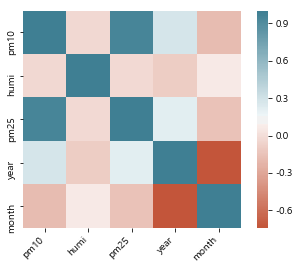

In [19]:
# 상관계수 heatmap 
ax = sns.heatmap(corr1, cmap=sns.diverging_palette(20, 220, n=200), square=True)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')

## 결측치, 이상치 처리

In [20]:
# 앞에서 'pm25'에 대한 처리를 해서 따로 결측치는 존재하지 않음
air1.isnull().sum().to_frame().sort_values(by = 0,ascending = False)

,0
tm,0
serial,0
flag,0
pm10,0
noise,0
temp,0
humi,0
pm25,0
year,0
month,0


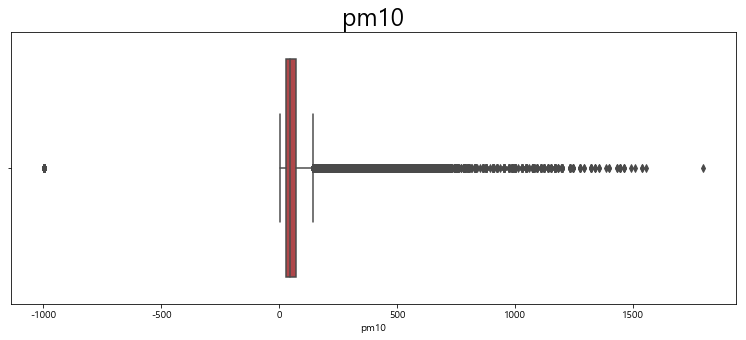

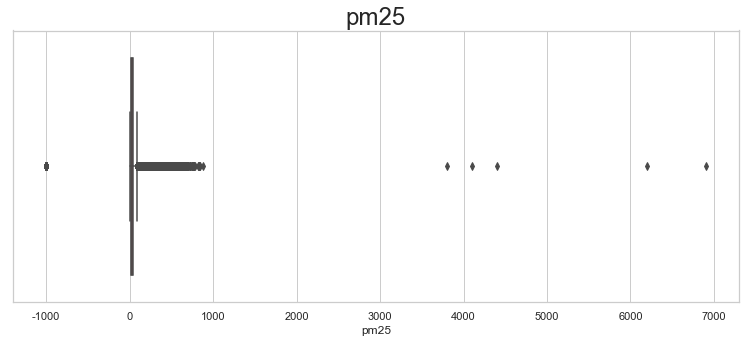

In [21]:
variable2 = ['pm10','pm25']

for a in variable2:
    plt.figure(figsize=(13,5))
    plt.title(a,size=24)
    sns.set(style = 'whitegrid',
       palette = 'RdBu')
    sns.boxplot(x = air1[a])

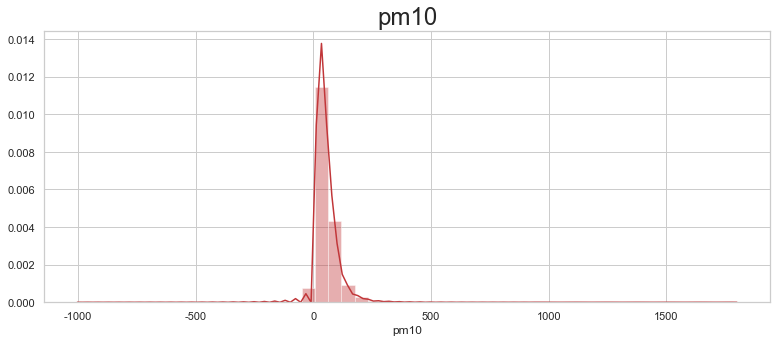

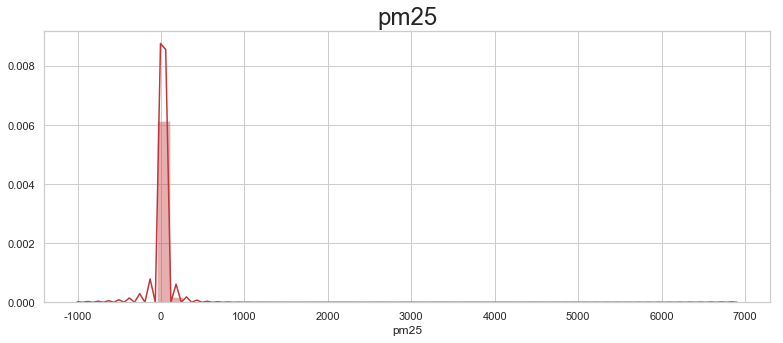

In [22]:
variable1 = ['pm10','pm25']

for a in variable1:
    sns.set(style = 'whitegrid',palette = 'RdBu')
    plt.figure(figsize=(13,5))
    plt.title(a,size=24)
    sns.distplot(air1[a])

###  'pm10', 'pm25' 이상치 관련
- 'pm10', 'pm25'는 미세먼지의 수치로 음수 값이 나올 수 없음 
- 1000 이상값은 유효한 값? 

<이상치 관련 문의 답변>
1. 종로구

*지점 : V10O1611289 , 날짜 : 201808290738 , pm2.5 : 4406

*지점 : V10O1611698 , 날짜 : 201804031938 , pm2.5 : 6900

2. 노원구

*지점 : V10O1611097 , 날짜 : 201807160538 , pm2.5 : 4104

*지점 : V10O1611100 , 날짜 : 201806160646 , pm10 : 1057

*지점 : V10O1611100 , 날짜 : 201808311238 , pm2.5 : 3803
- 위 지점들은 이상치로 간주


확인 및 제거

In [23]:
# 해당 serial과 시간의 pm2.5값 : 4406 #
air1[(air1['serial'] == 'V10O1611289') &
     (air1['year'] == 2018) &
     (air1['month'] == 8) &
     (air1['day'] == 29) &
     (air1['hour'] == 7) &
     (air1['minute'] == 38)] 

,tm,serial,flag,pm10,noise,temp,humi,pm25,year,month,day,hour,minute,gu,location,district
17264618,2018-08-29 07:38:00,V10O1611289,1,44,45,26.7,76,4406.0,2018,8,29,7,38,jonglo,영천동 277,천연동


맥락을 살펴보기 위해 'serial'값이 'V10O1611289'인 'pm25'의 값을 시간순으로 line floating하면 다음과 같다.
- 미세먼지 농도의 일정한 트렌드(감소 추세, 상승 추세)없이 도출된 값이 기록됨을 확인할 수 있다.

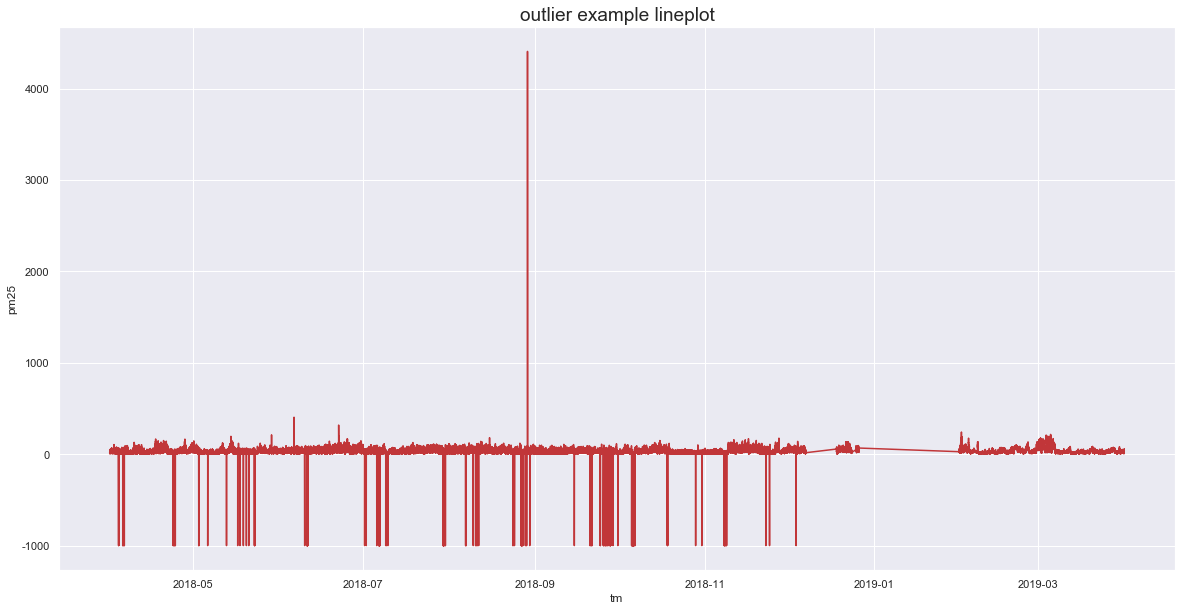

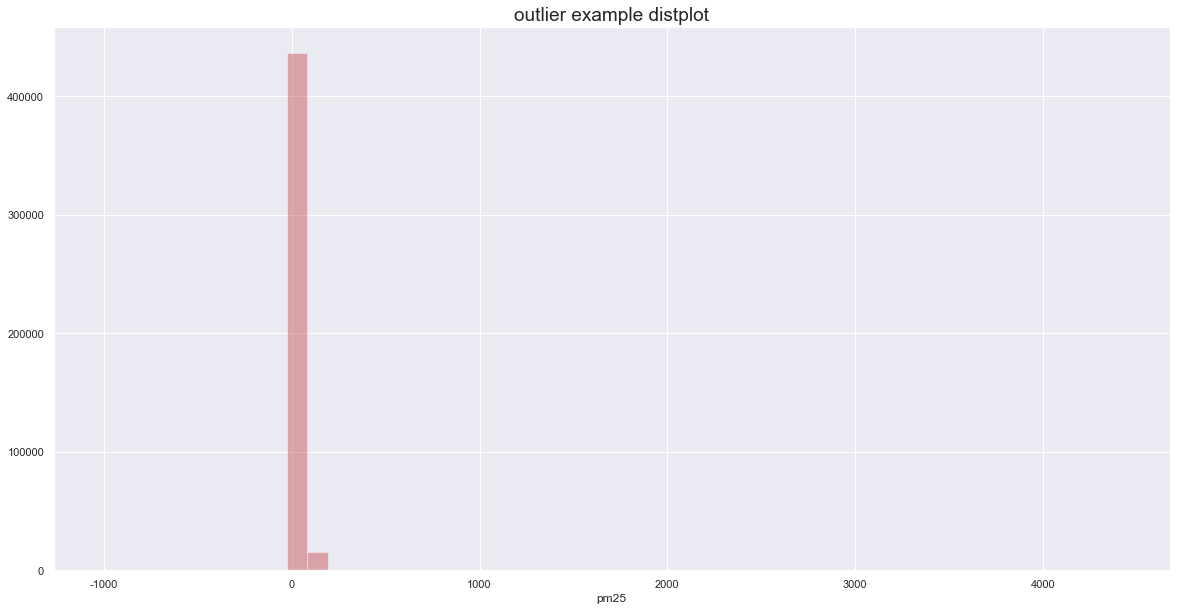

In [ ]:
sns.set(style='darkgrid',palette = 'RdBu')
plt.figure(figsize = (20,10))
plt.title('outlier example lineplot',size=19)
sns.lineplot(x='tm',y='pm25',data=air1[air1['serial']=='V10O1611289'])
print()
sns.set(style='darkgrid',palette = 'RdBu')
plt.figure(figsize = (20,10))
plt.title('outlier example distplot',size=19)
sns.distplot(air1[air1['serial']=='V10O1611289']['pm25'],kde=False)

주최측에서 밝힌 노원구에서 발생한 미세먼지 이상치를 확인할 때, 위와 같은 특징을 공유함을 확인할 수 있다.

In [ ]:
# 해당 serial과 시간의 pm2.5값 : 4104 #
air1[(air1['serial'] == 'V10O1611097') &
     (air1['year'] == 2018) &
     (air1['month'] == 7) &
     (air1['day'] == 16) &
     (air1['hour'] == 5) &
     (air1['minute'] == 38)] 

,tm,serial,flag,pm10,noise,temp,humi,pm25,year,month,day,hour,minute,gu,location,district
5027378,2018-07-16 05:38:00,V10O1611097,1,41,50,26.1,75,4104.0,2018,7,16,5,38,nowon,중계동 513,"중계2,3동"


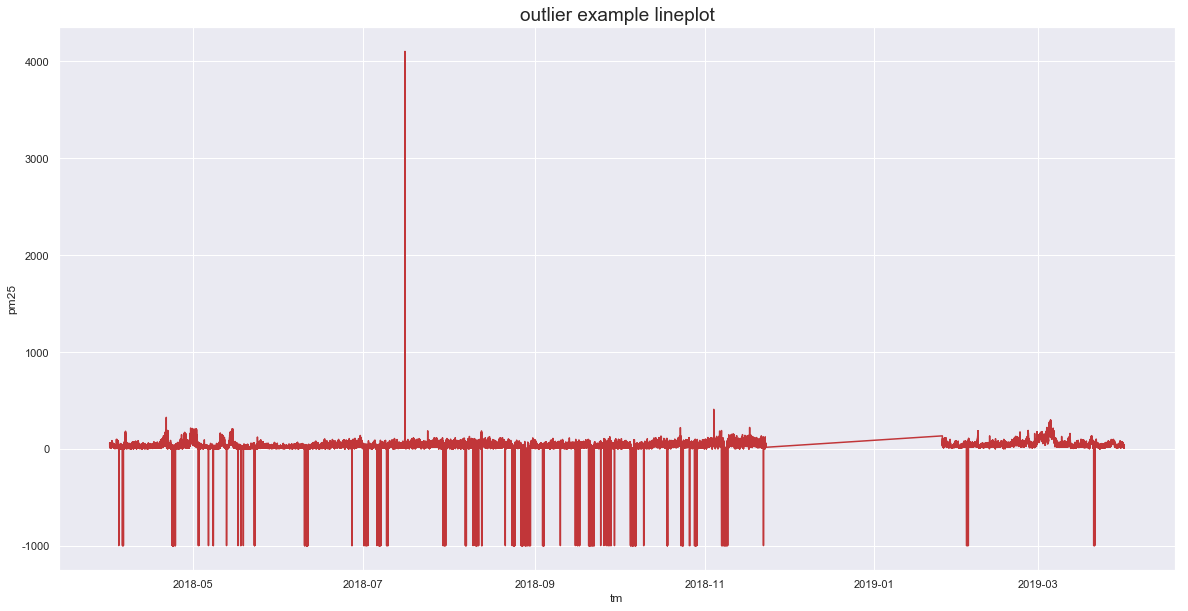

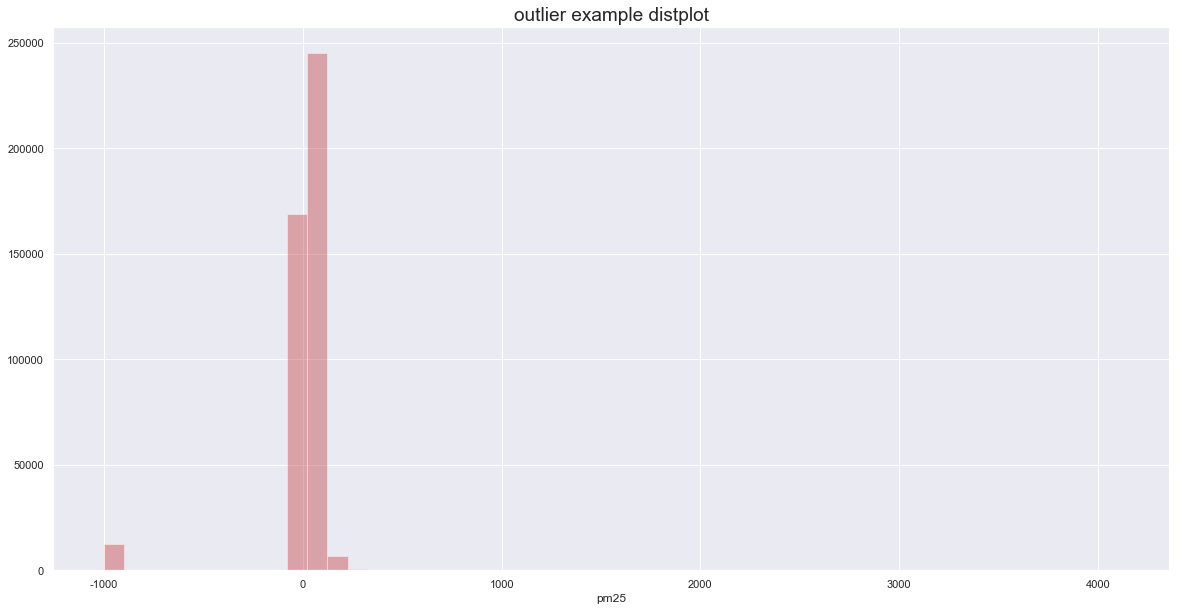

In [ ]:
sns.set(style='darkgrid',palette = 'RdBu')
plt.figure(figsize = (20,10))
plt.title('outlier example lineplot',size=19)
sns.lineplot(x='tm',y='pm25',data=air1[air1['serial']=='V10O1611097'])
print()
sns.set(style='darkgrid',palette = 'RdBu')
plt.figure(figsize = (20,10))
plt.title('outlier example distplot',size=19)
sns.distplot(air1[air1['serial']=='V10O1611097']['pm25'],kde=False)

### 'noise', 'temp', 'humi' 이상치 관련
- 'noise', 'humi'는 소음, 습도 데이터로 음수 값이 나올 수 없음 
- 'temp'는 온도 데이터로 -30℃ 미만은 나올 수 없음

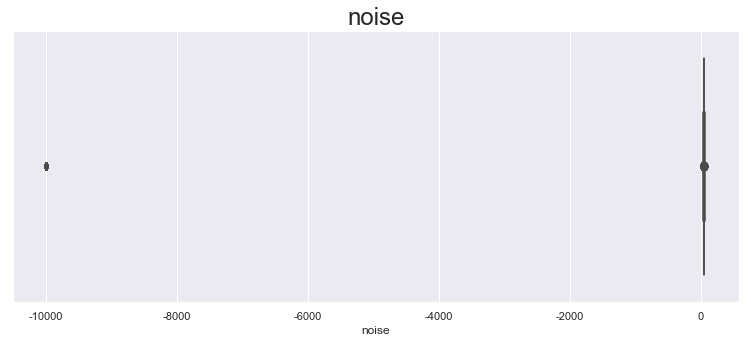

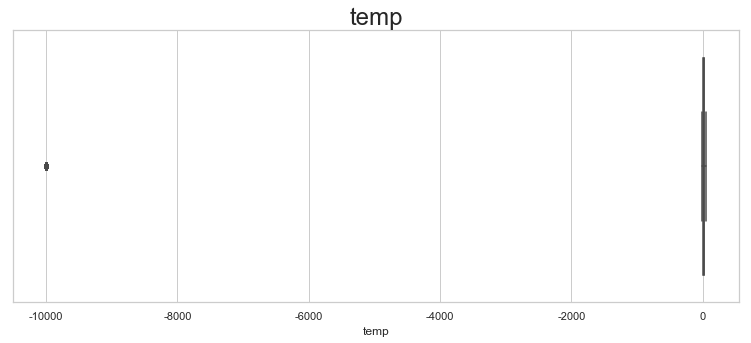

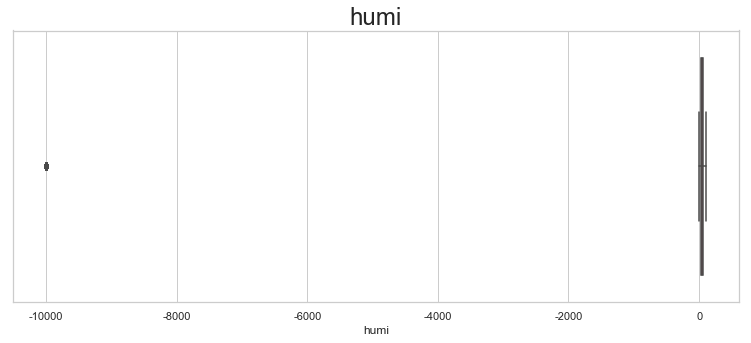

In [ ]:
variable3 = ['noise','temp','humi']

for a in variable3:
    plt.figure(figsize=(13,5))
    plt.title(a,size=24)
    sns.set(style = 'whitegrid',palette = 'RdBu')
    sns.boxplot(x = air1[a])
    plt.show()

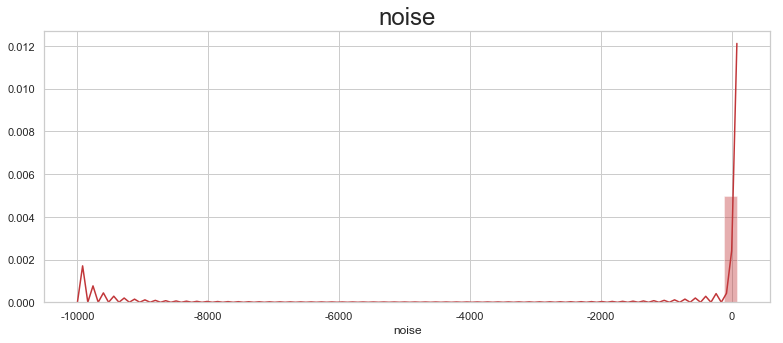

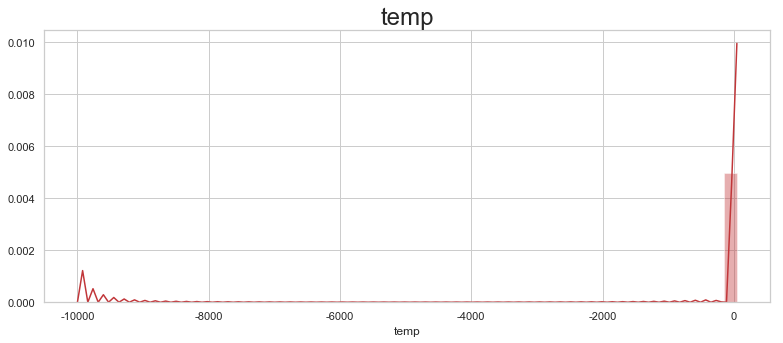

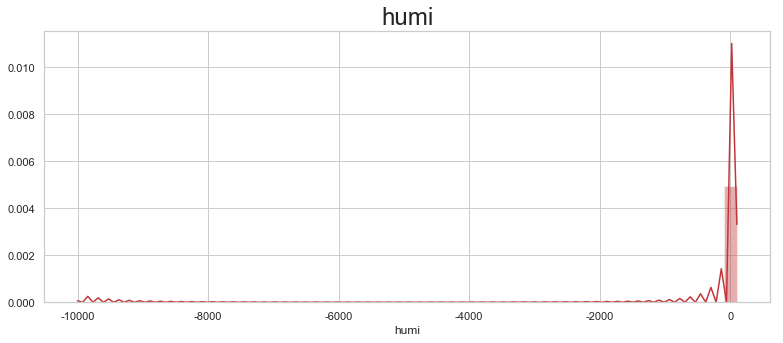

In [ ]:
variable2 = ['noise','temp','humi']

for a in variable2:
    sns.set(style = 'whitegrid',palette = 'RdBu')
    plt.figure(figsize=(13,5))
    plt.title(a,size=24)
    sns.distplot(air1[a])

### 'serial'를 구로 분리

In [ ]:
serial_1 = np.unique(air1['serial'])
serial_1

array(['V10O1610102', 'V10O1610200', 'V10O1610252', 'V10O1610293',
       'V10O1610297', 'V10O1610312', 'V10O1610351', 'V10O1610356',
       'V10O1610376', 'V10O1610540', 'V10O1610542', 'V10O1610543',
       'V10O1610544', 'V10O1610545', 'V10O1610546', 'V10O1610567',
       'V10O1610610', 'V10O1610616', 'V10O1610629', 'V10O1610630',
       'V10O1610642', 'V10O1610643', 'V10O1611097', 'V10O1611100',
       'V10O1611102', 'V10O1611104', 'V10O1611145', 'V10O1611150',
       'V10O1611151', 'V10O1611170', 'V10O1611172', 'V10O1611173',
       'V10O1611220', 'V10O1611229', 'V10O1611251', 'V10O1611255',
       'V10O1611258', 'V10O1611289', 'V10O1611623', 'V10O1611634',
       'V10O1611639', 'V10O1611645', 'V10O1611652', 'V10O1611658',
       'V10O1611684', 'V10O1611698', 'V10O1611722', 'V10O1611750',
       'V10O1611887', 'V10O1612106', 'V10O1612113', 'V10O1612126'],
      dtype=object)

In [ ]:
n = list()
z = [n] * len(serial_1)
k = list()

for i in range(len(serial_1)):
    z[i] = air1[air1['serial'] == serial_1[i]]
for j in range(len(z)):
    length = z[j].shape[0]
    k.append(length)

d = pd.DataFrame(k,index = serial_1,columns = ['count'])
d

,count
V10O1610102,417423
V10O1610200,89216
V10O1610252,497926
V10O1610293,490990
V10O1610297,112653
V10O1610312,274703
V10O1610351,250895
V10O1610356,315298
V10O1610376,489980
V10O1610540,382233


In [ ]:
d.shape

(52, 1)

In [ ]:
nowon = air1[air1['gu'] == 'nowon']
jonglo = air1[air1['gu'] == 'jonglo']

###  'tm'기준 각 변수 그래프
#### nowon data - 'serial' 별  x = 'tm', y = 'pm10' 그래프

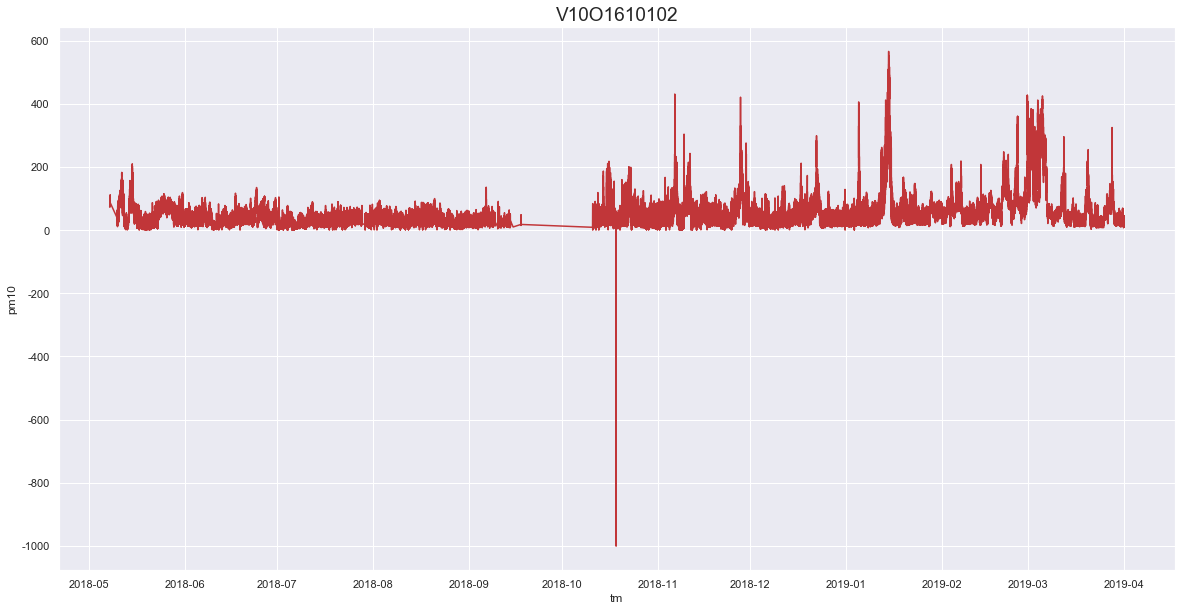

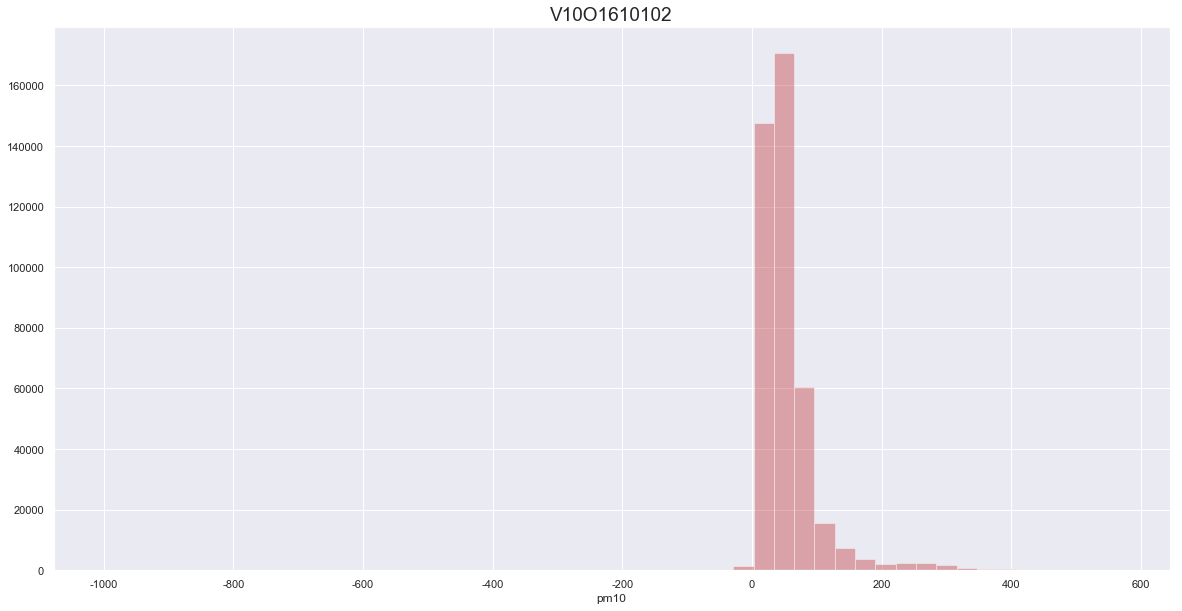

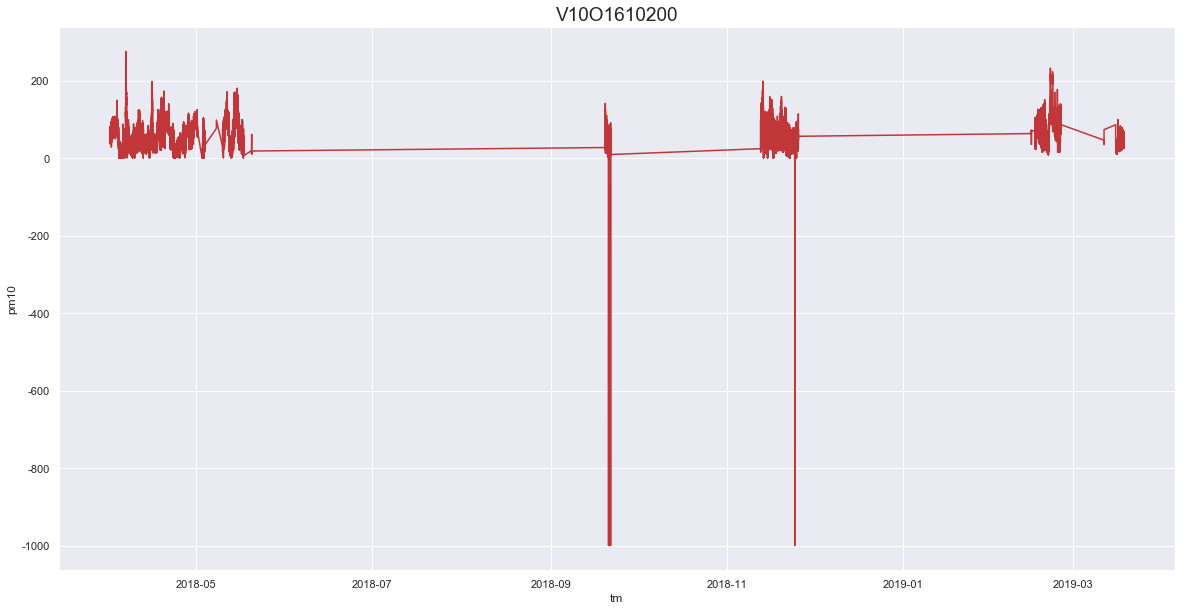

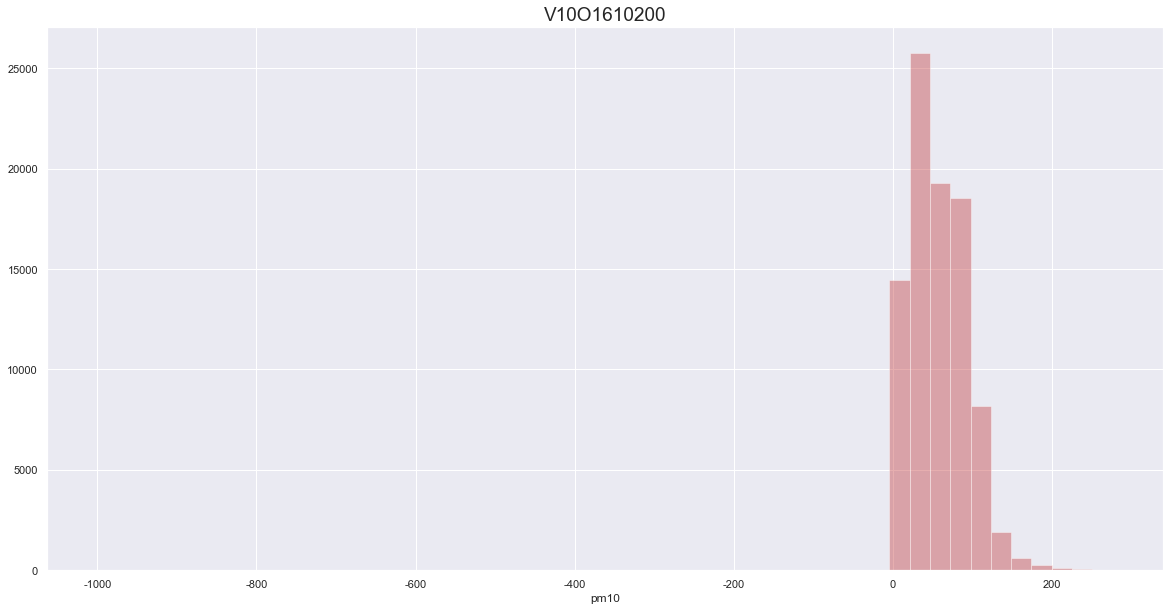

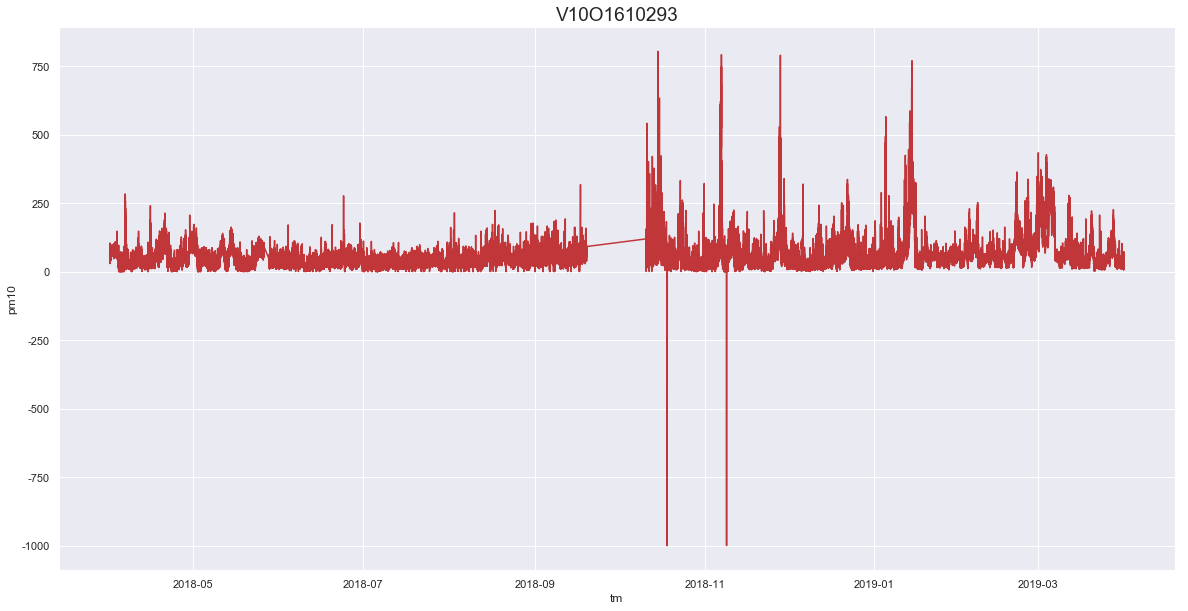

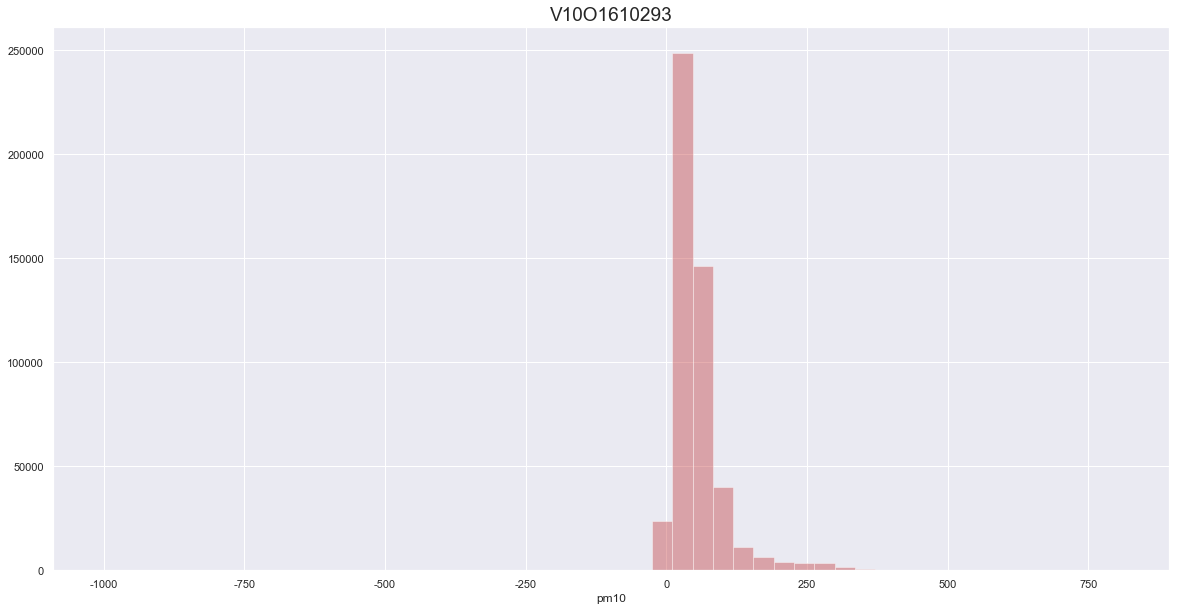

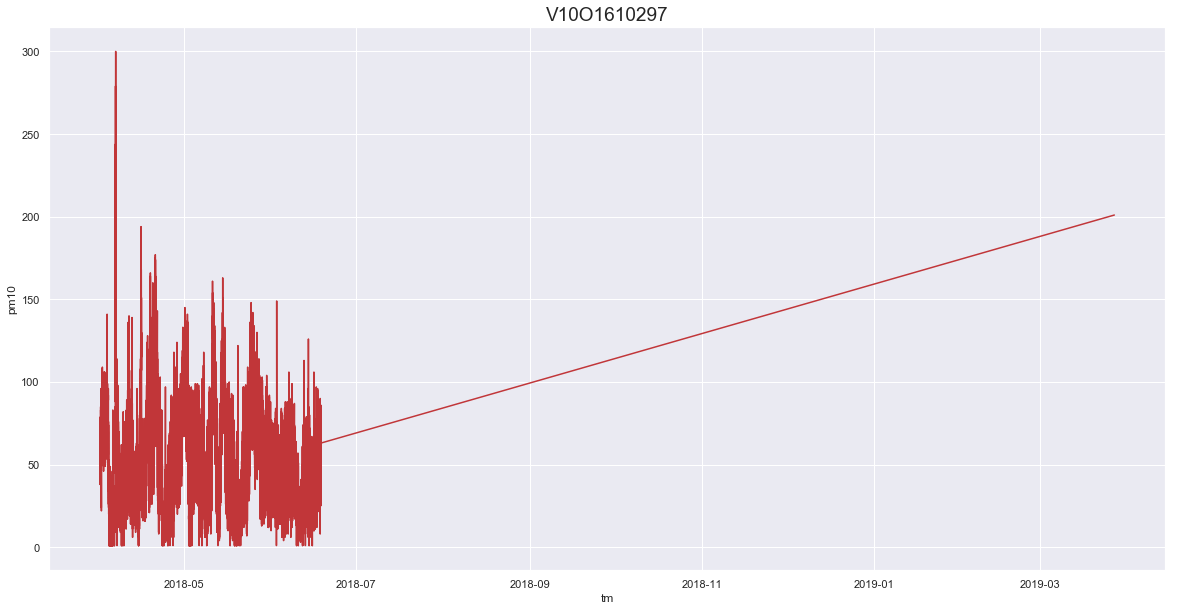

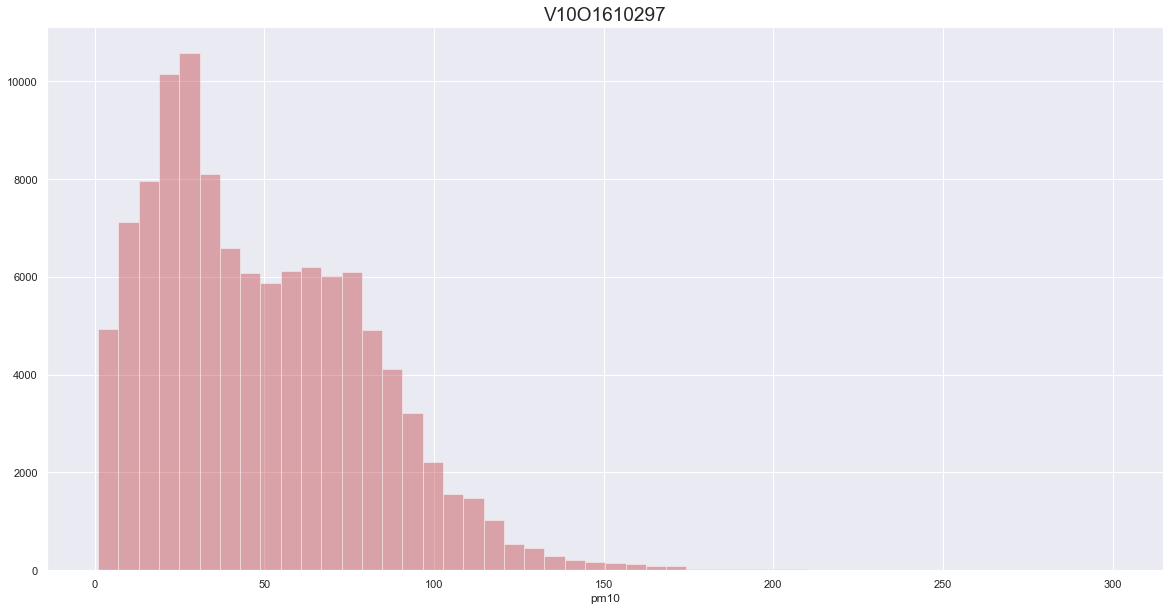

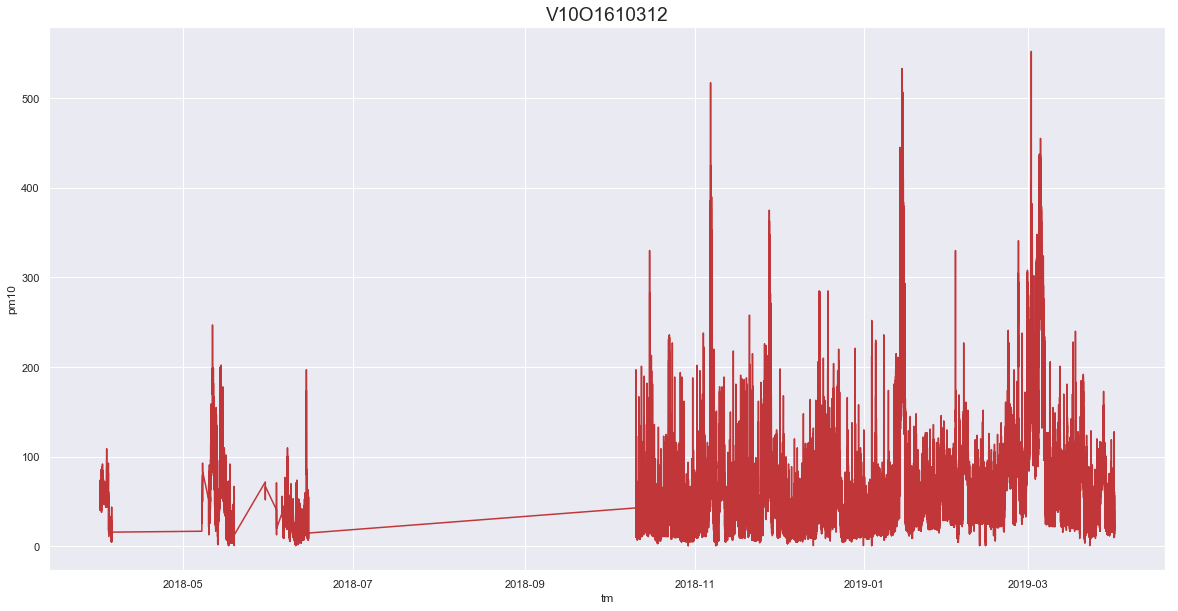

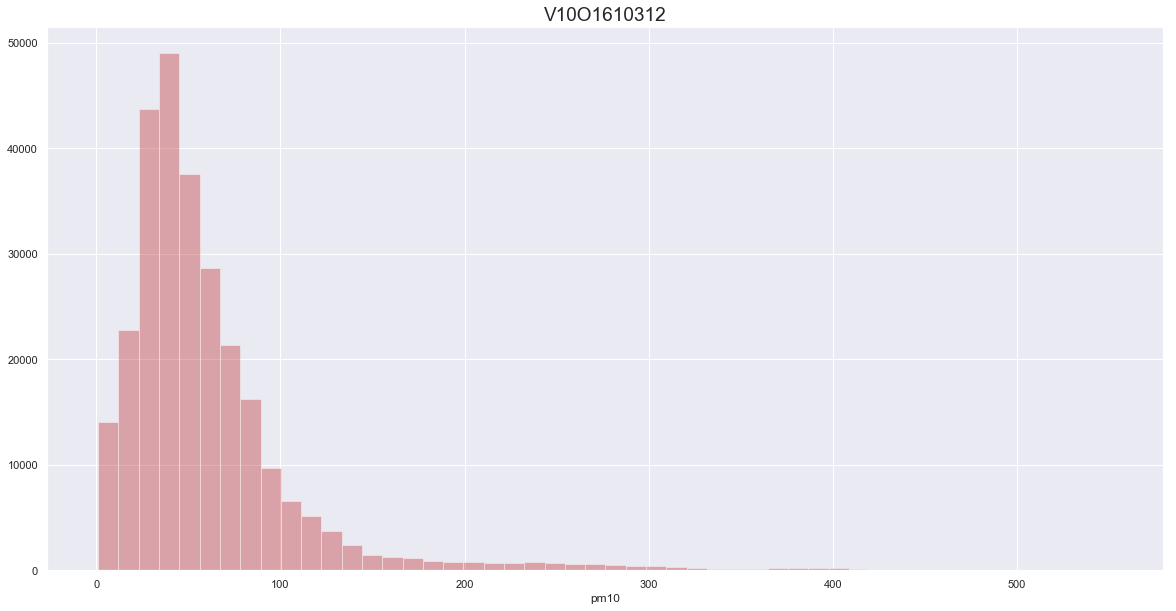

In [ ]:
# nowon['serial'] 0~4
for a in np.unique(nowon['serial'])[:5]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=nowon[nowon['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(nowon[nowon['serial']==a]['pm10'],kde=False)

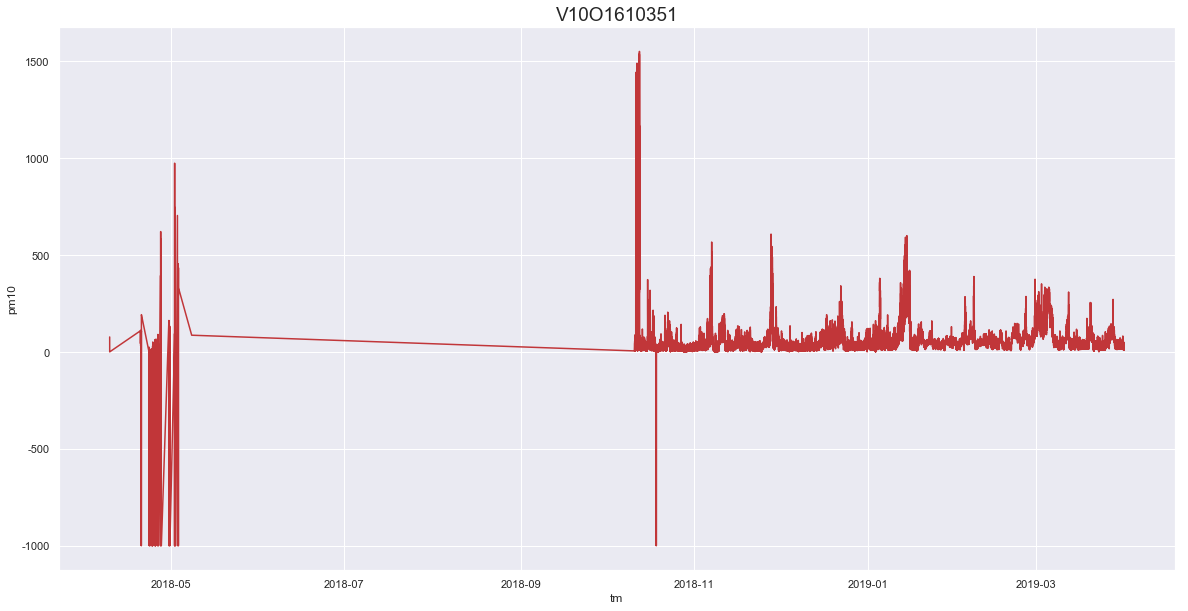

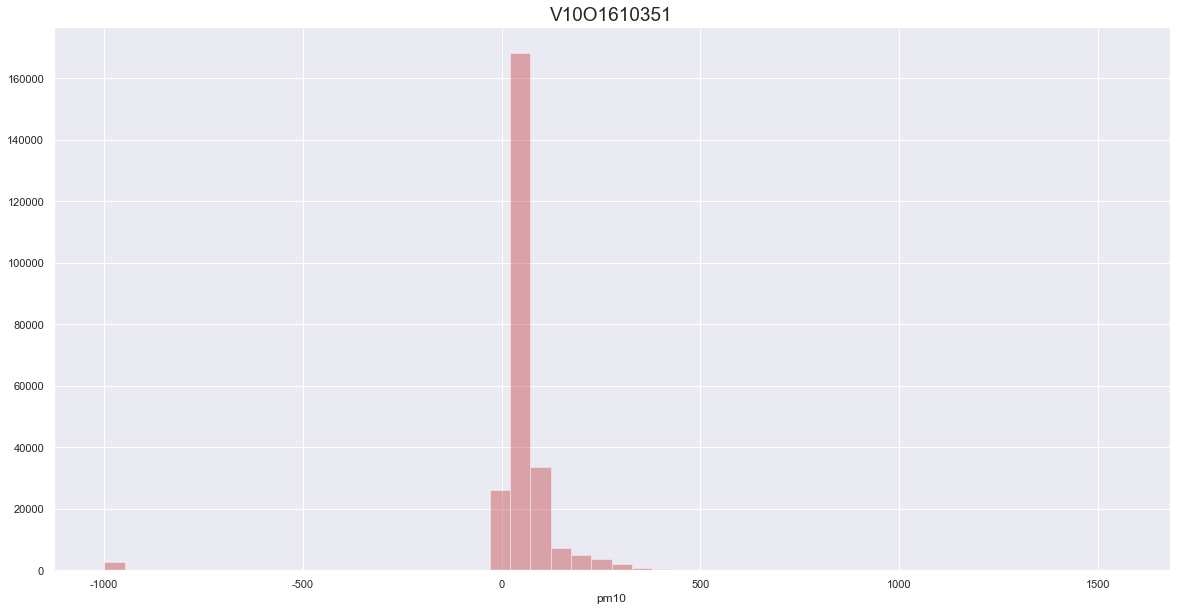

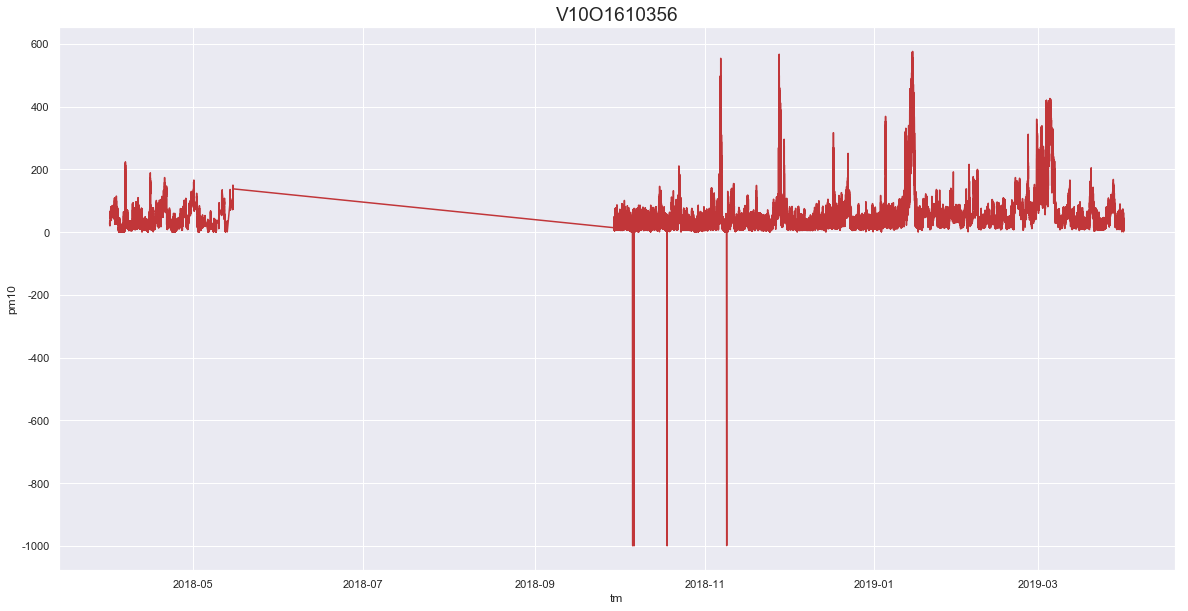

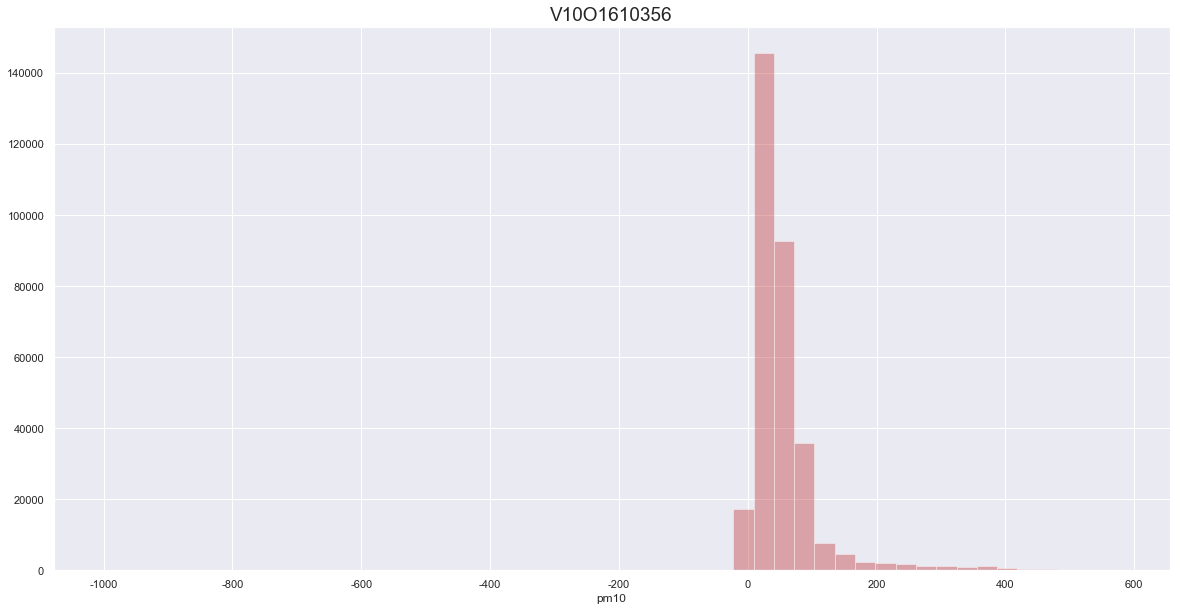

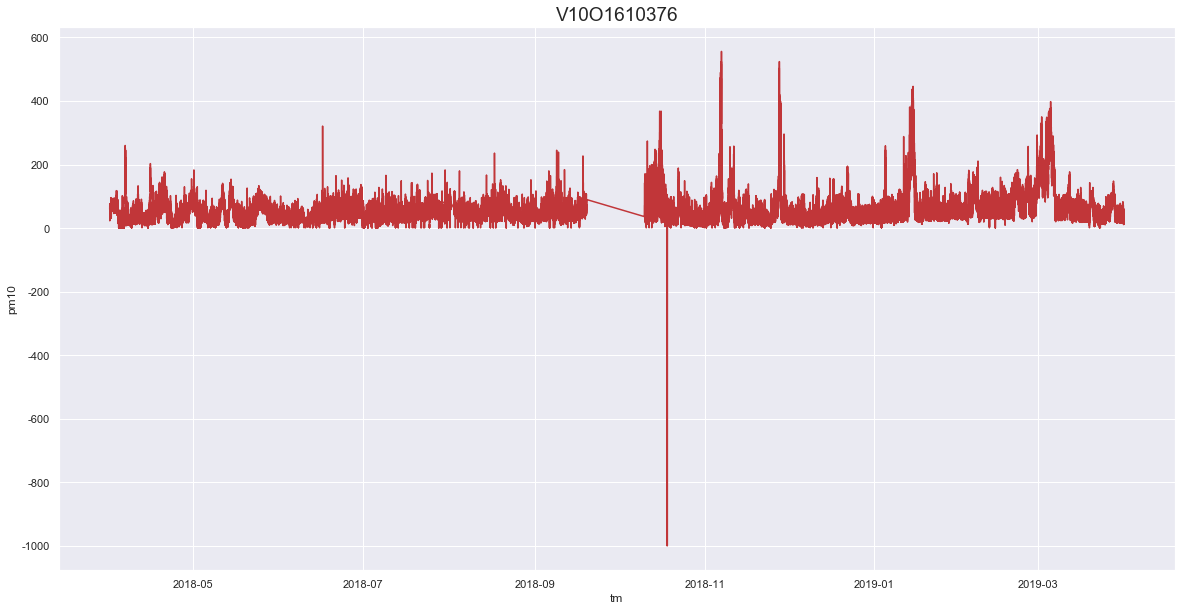

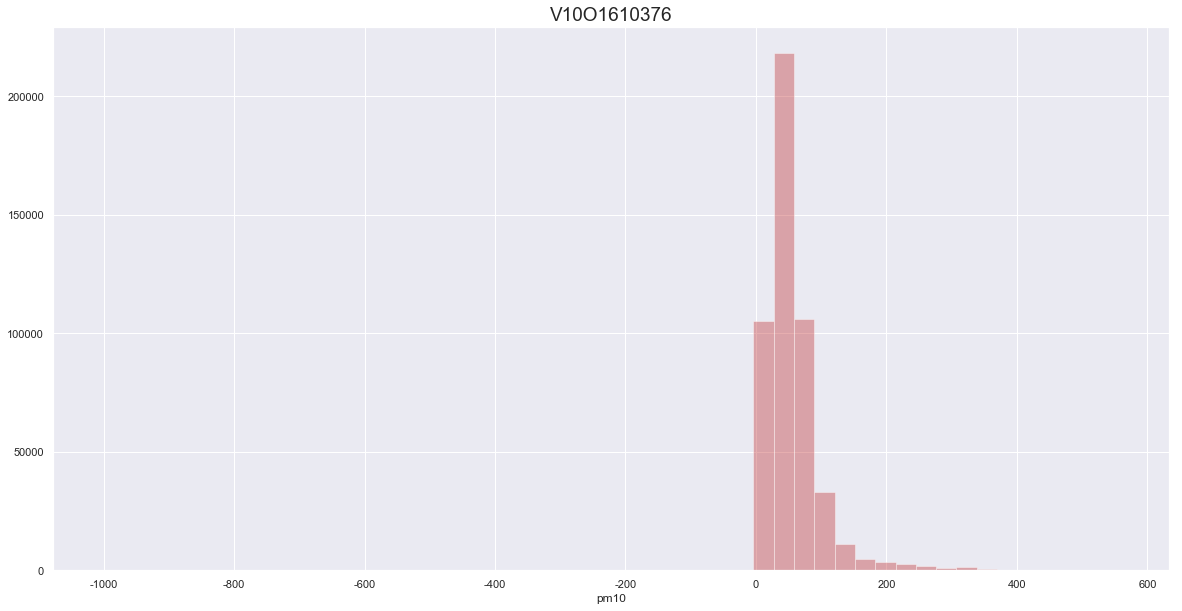

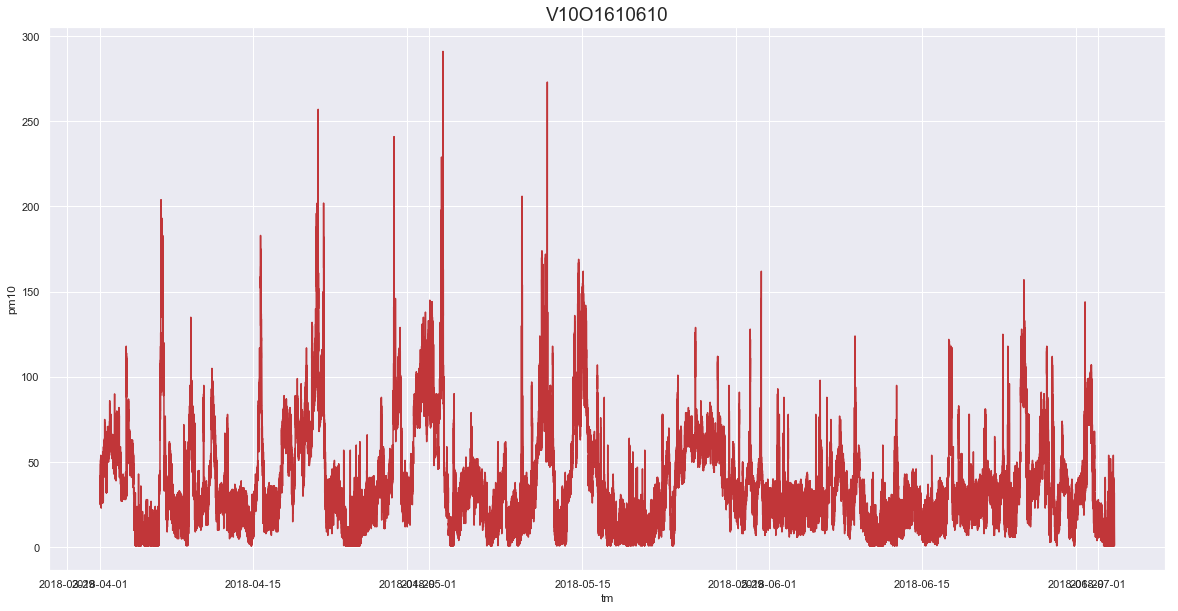

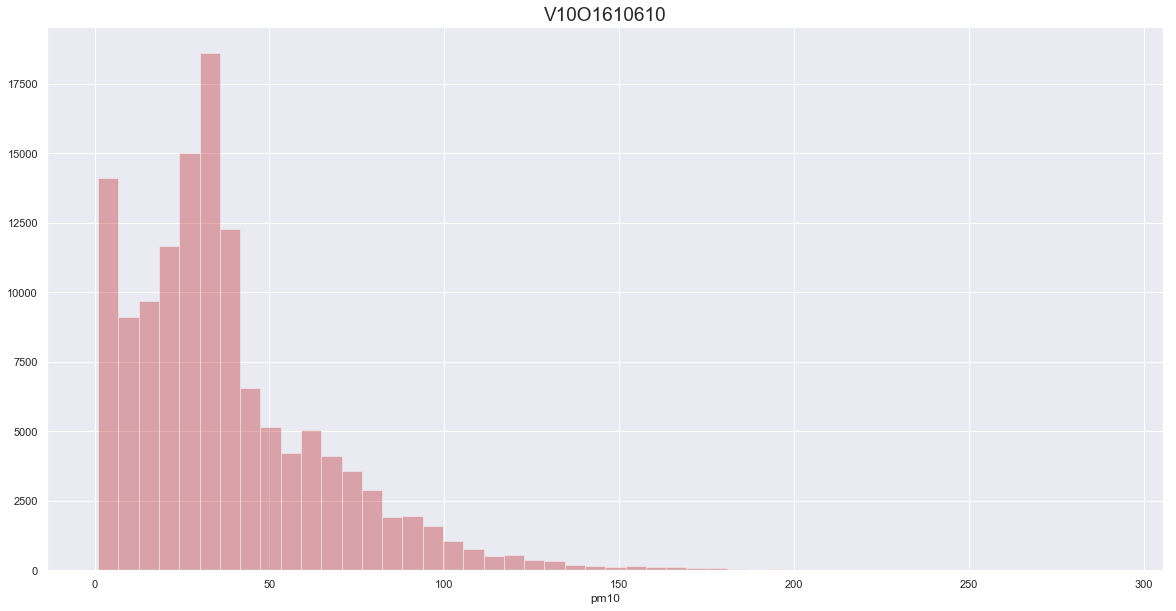

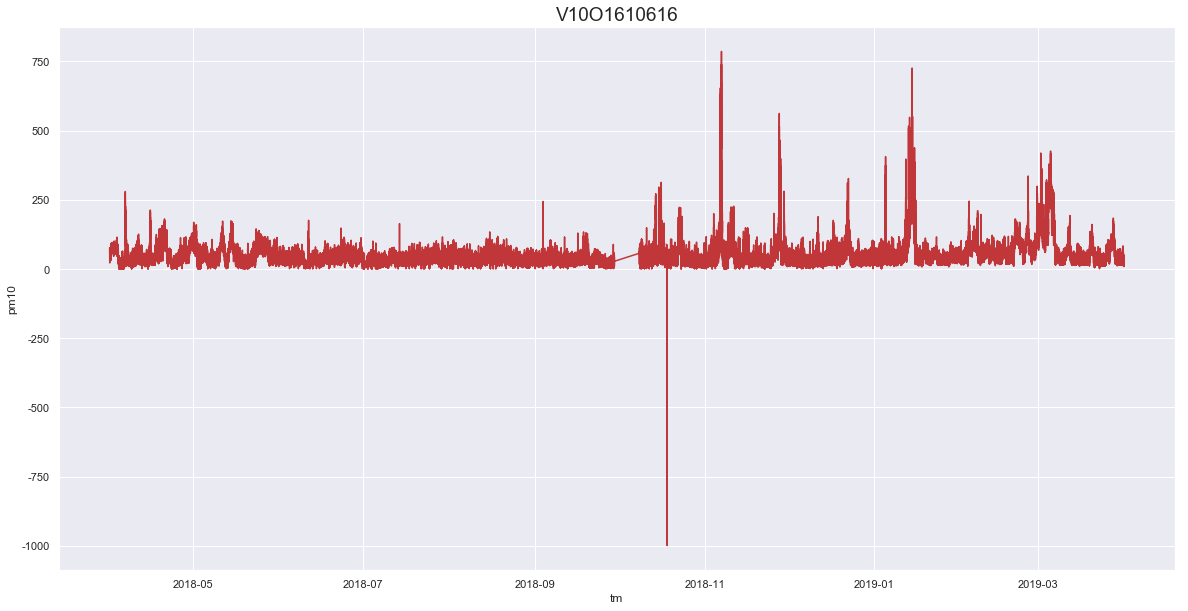

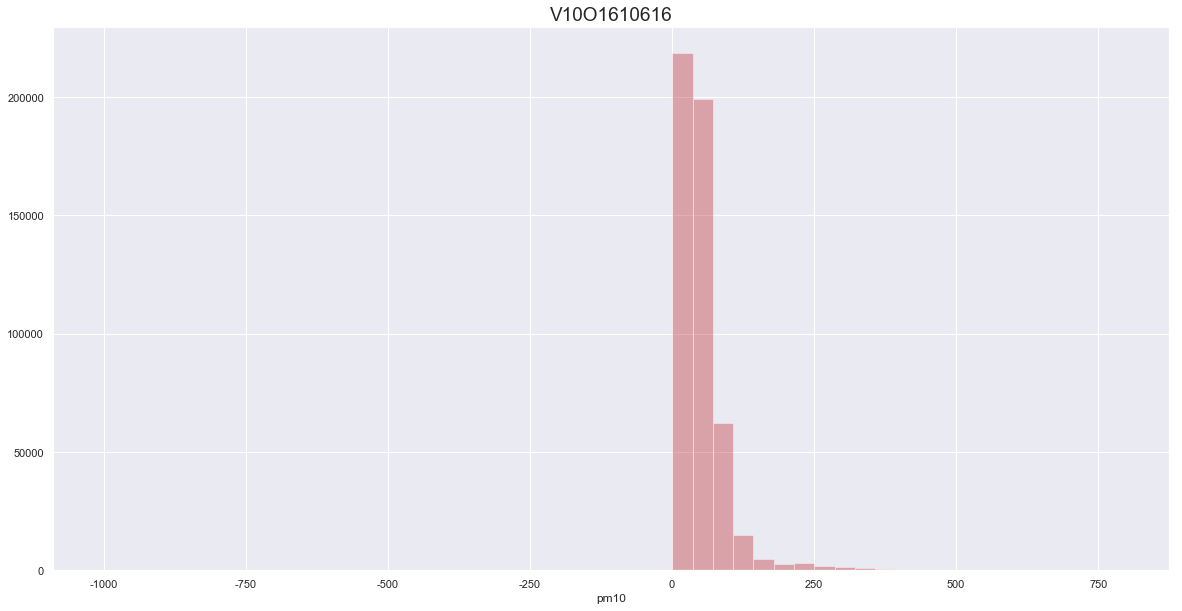

In [ ]:
# nowon['serial'] 5~9
for a in np.unique(nowon['serial'])[5:10]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=nowon[nowon['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(nowon[nowon['serial']==a]['pm10'],kde=False)

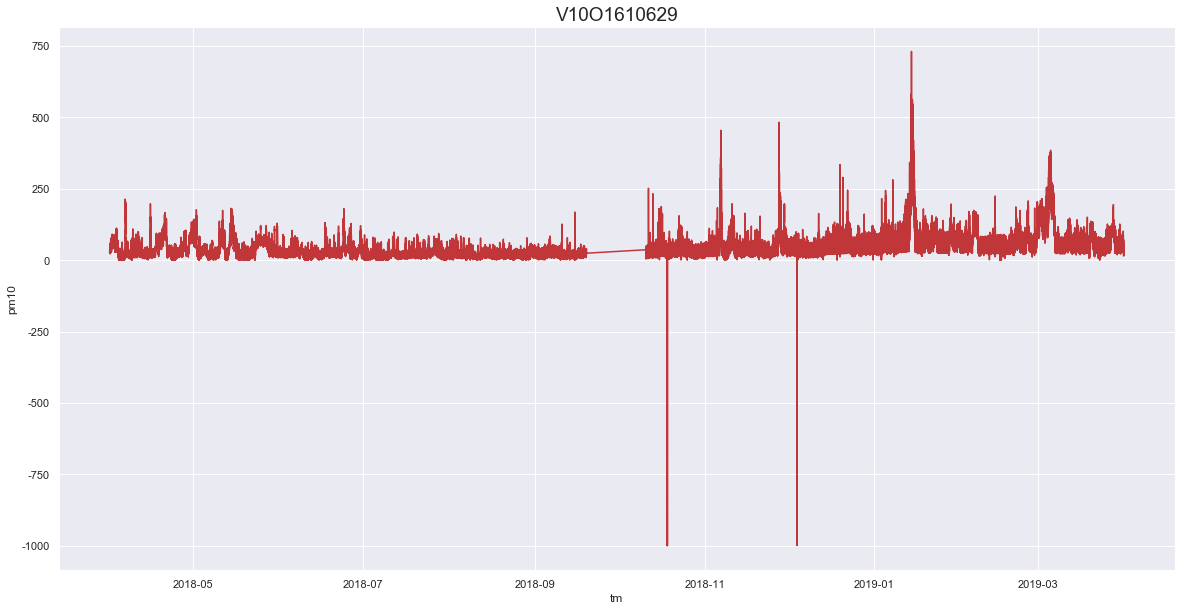

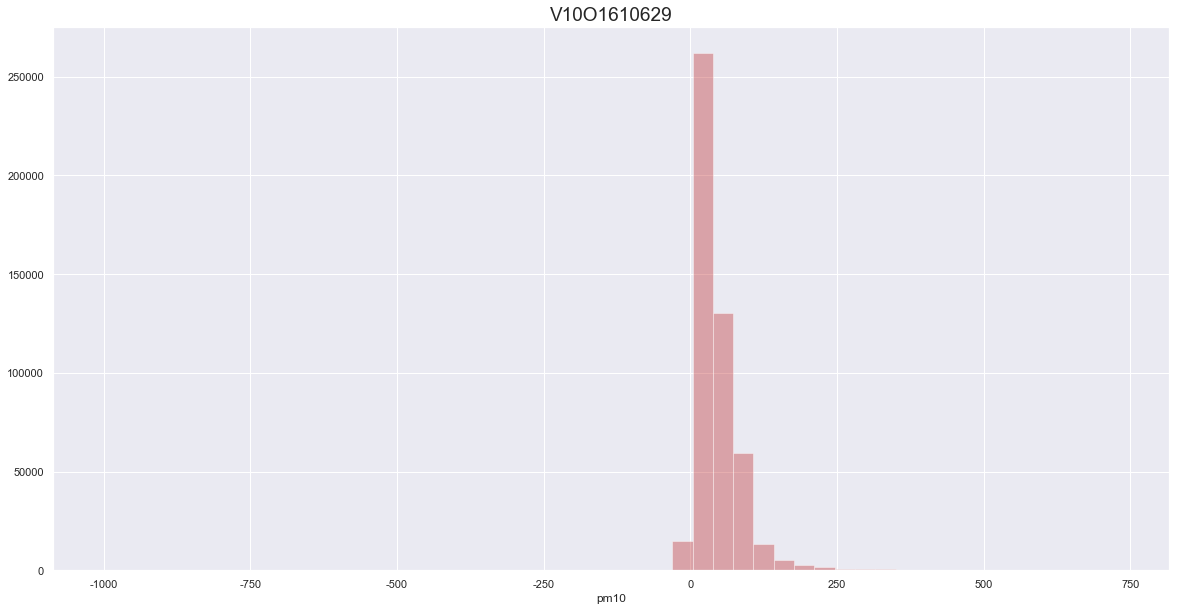

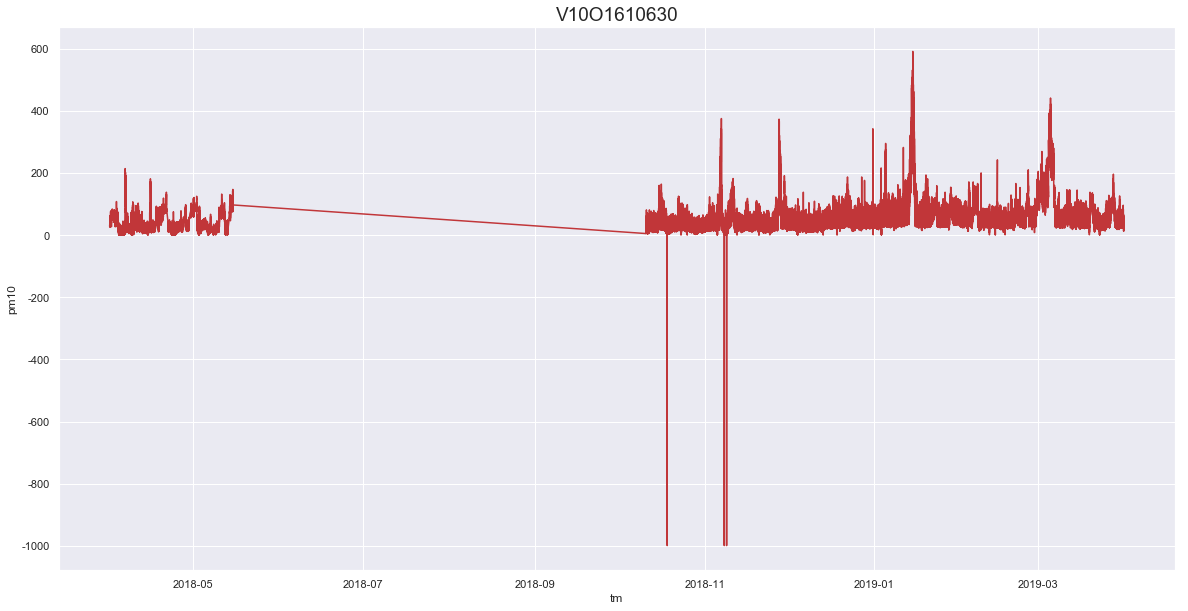

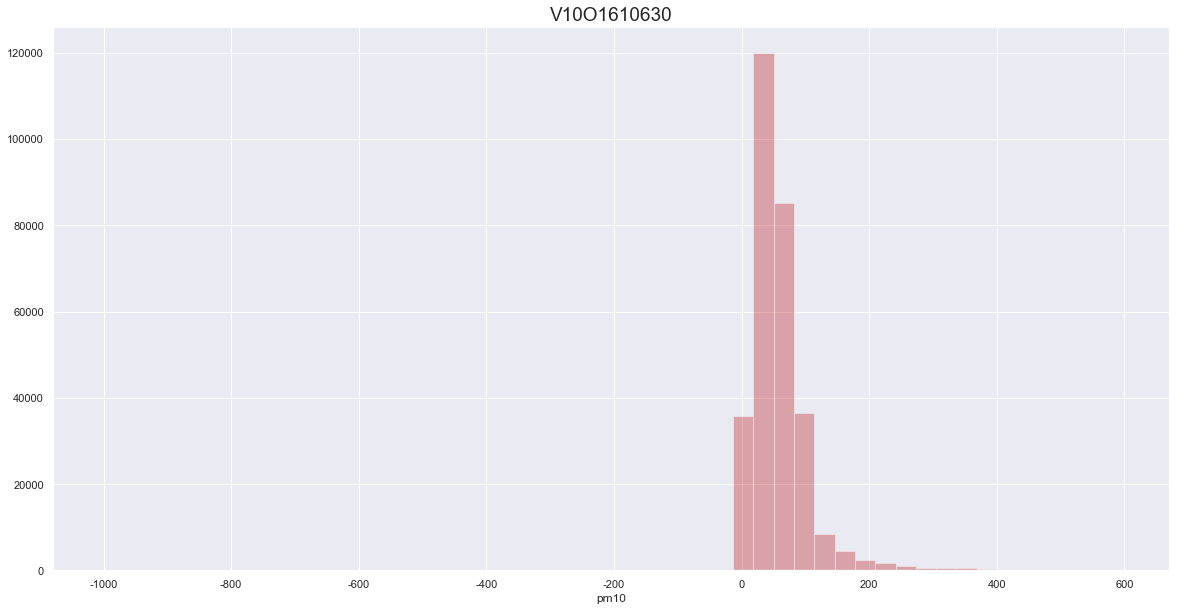

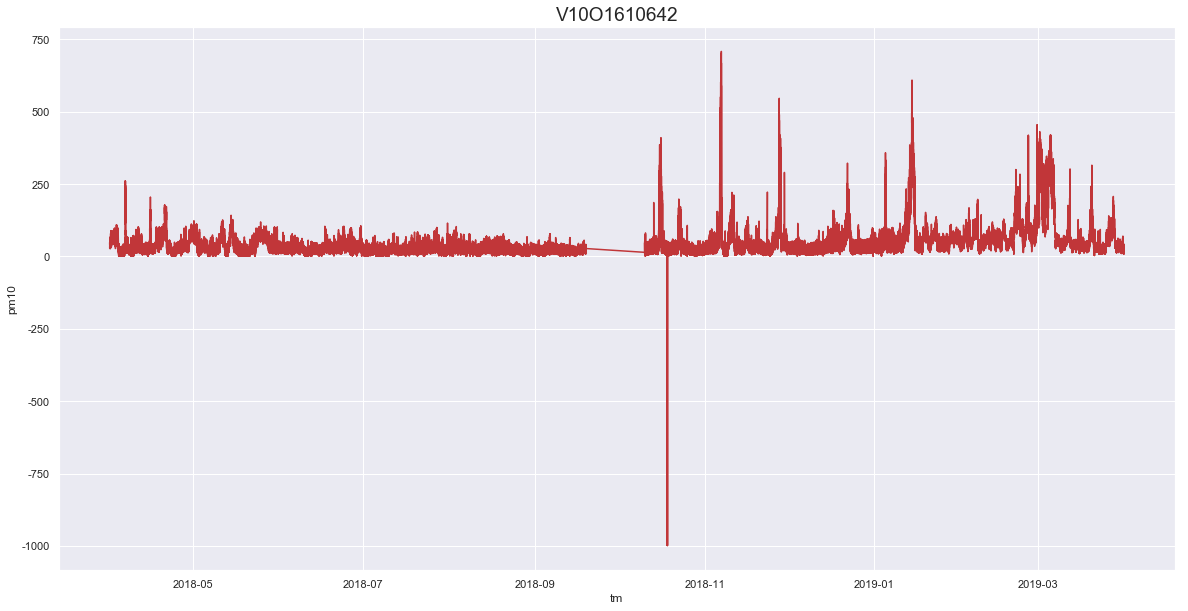

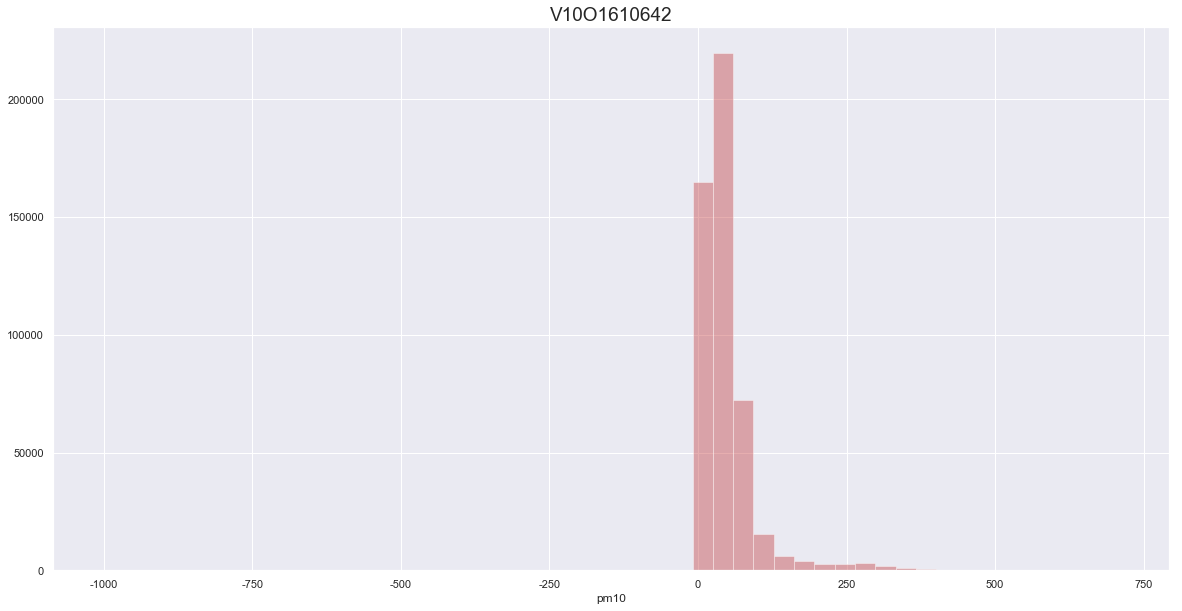

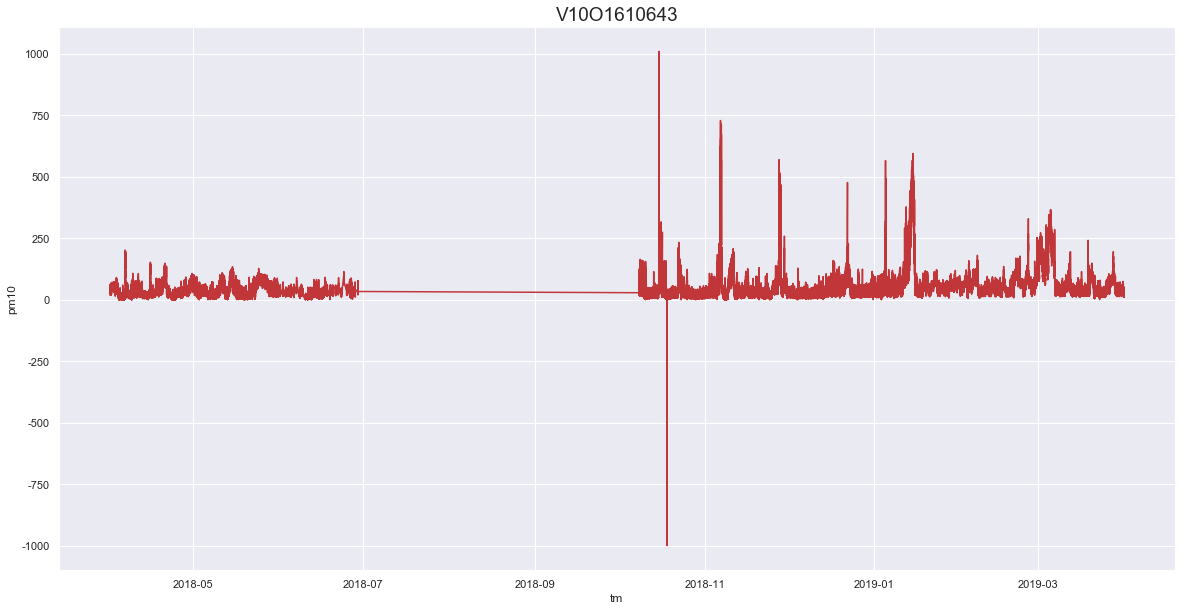

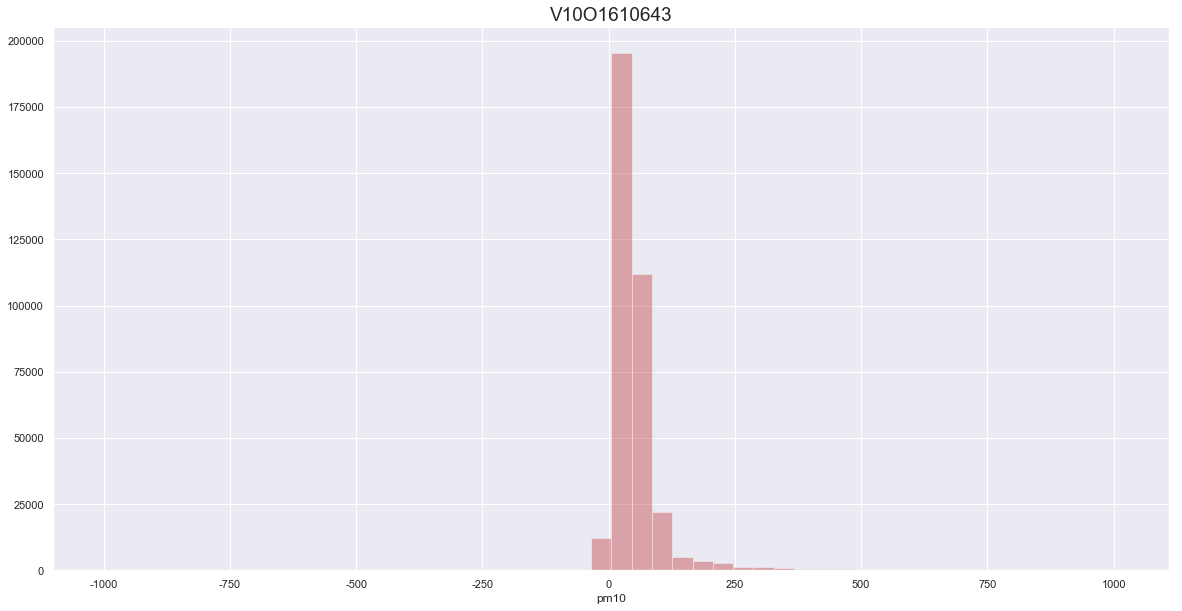

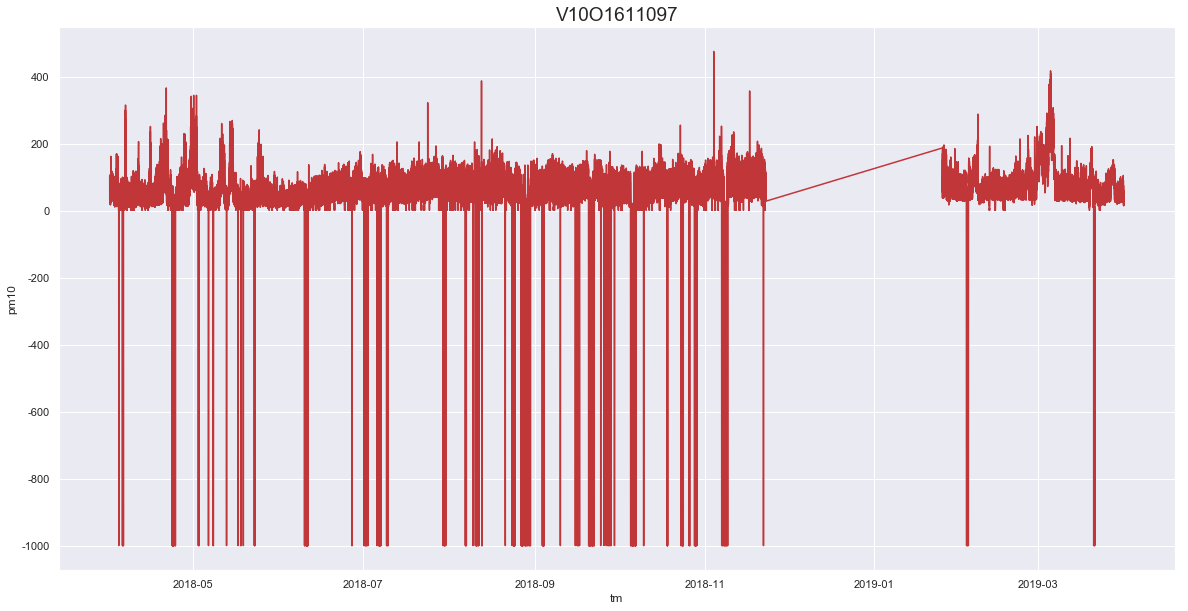

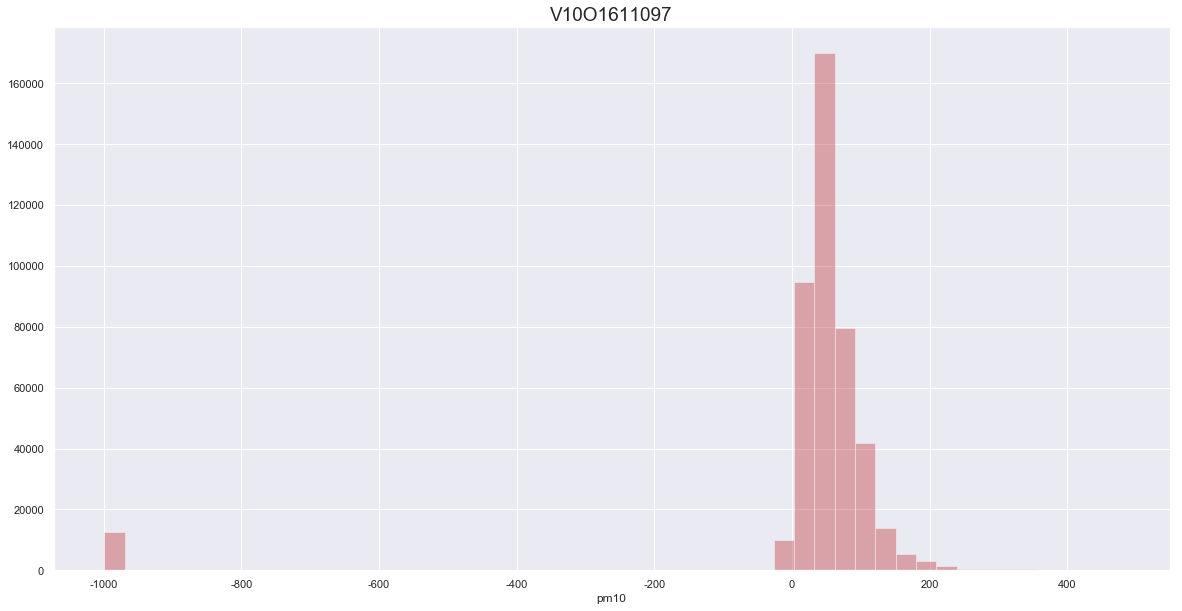

In [ ]:
# nowon['serial'] 10~14
for a in np.unique(nowon['serial'])[10:15]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=nowon[nowon['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(nowon[nowon['serial']==a]['pm10'],kde=False)

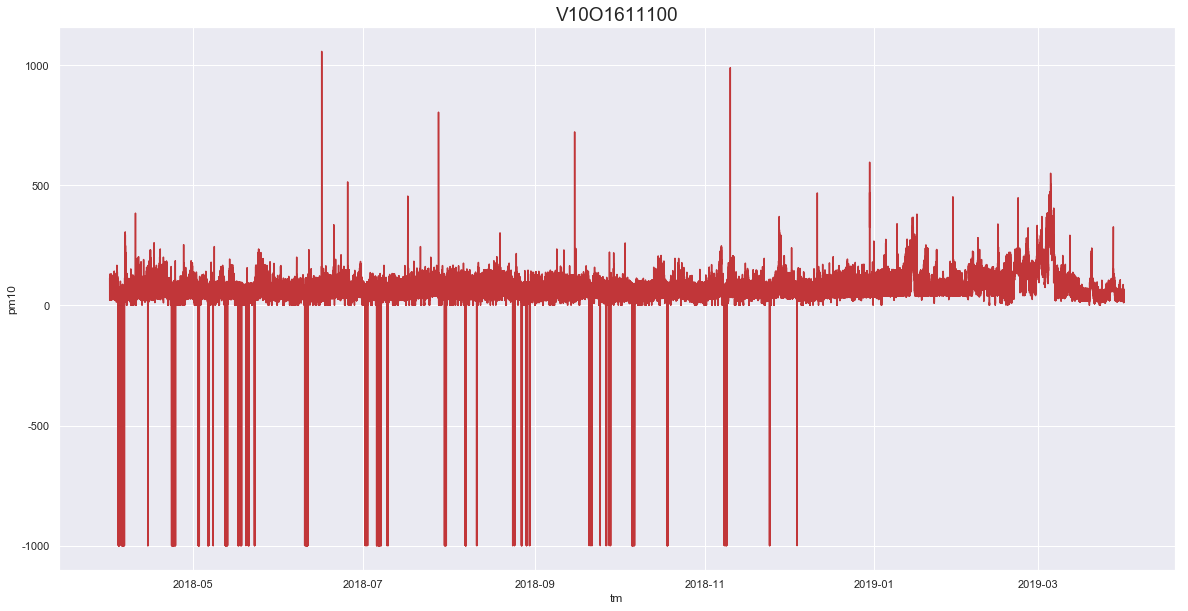

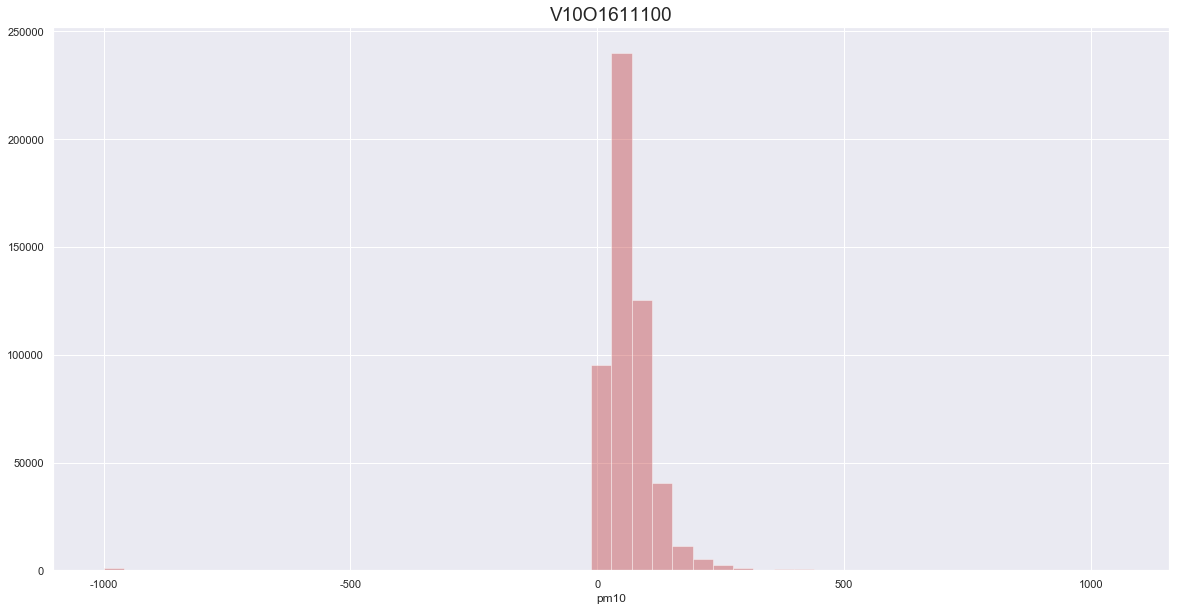

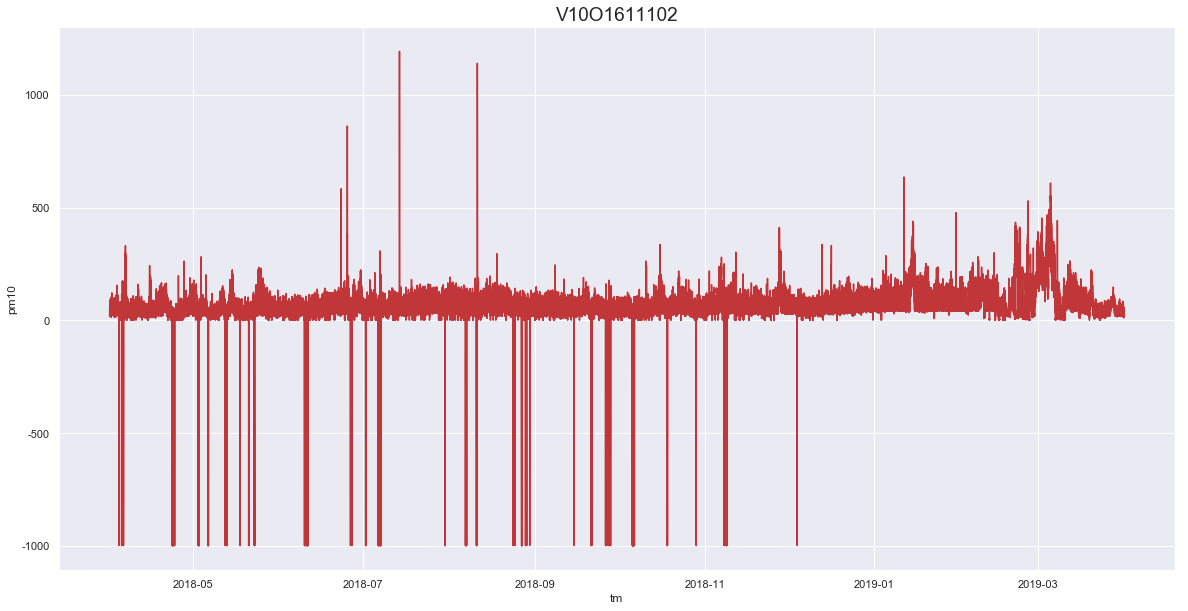

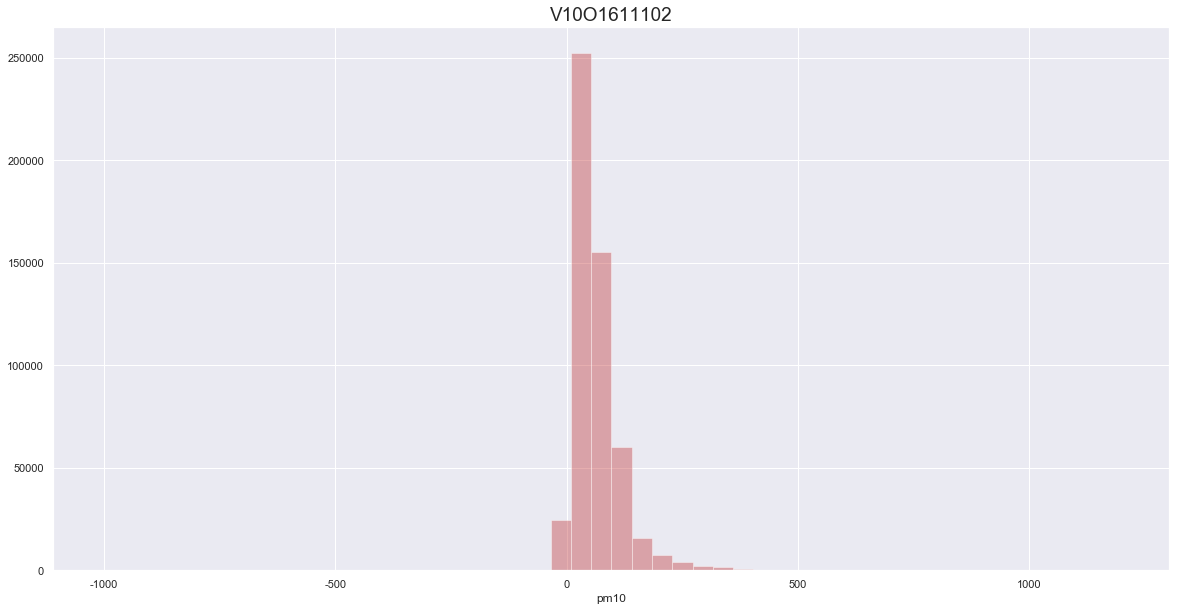

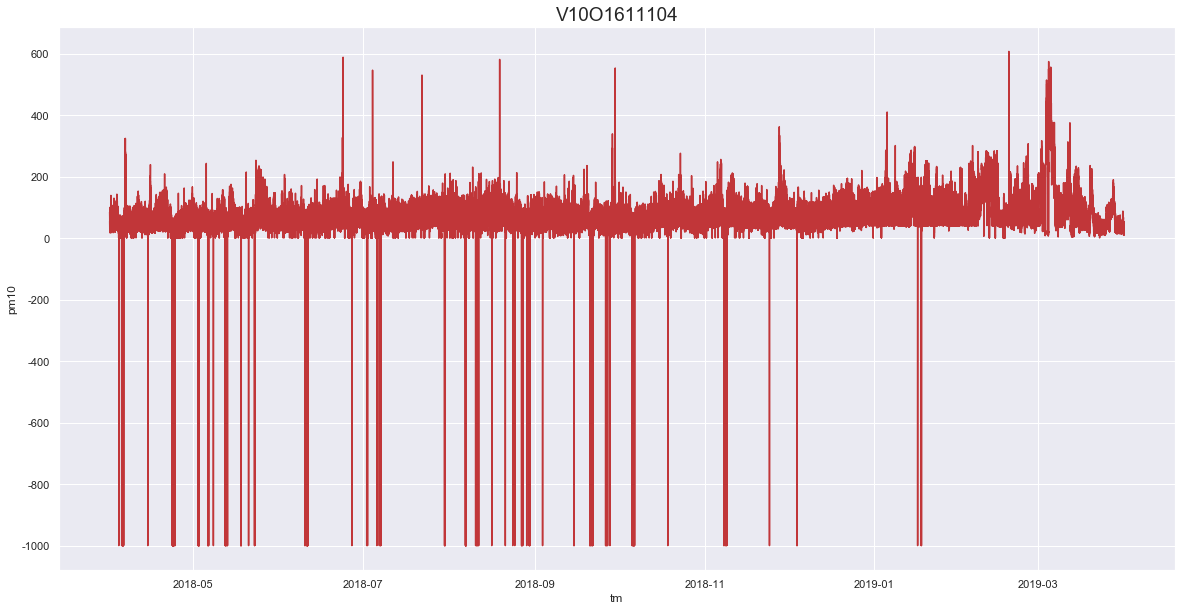

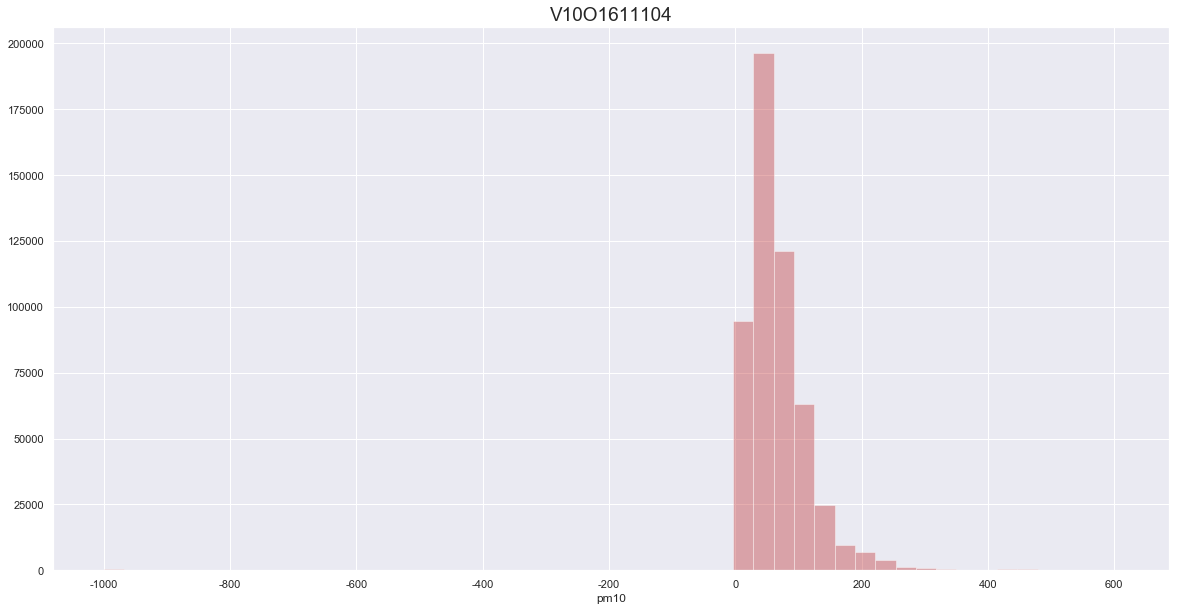

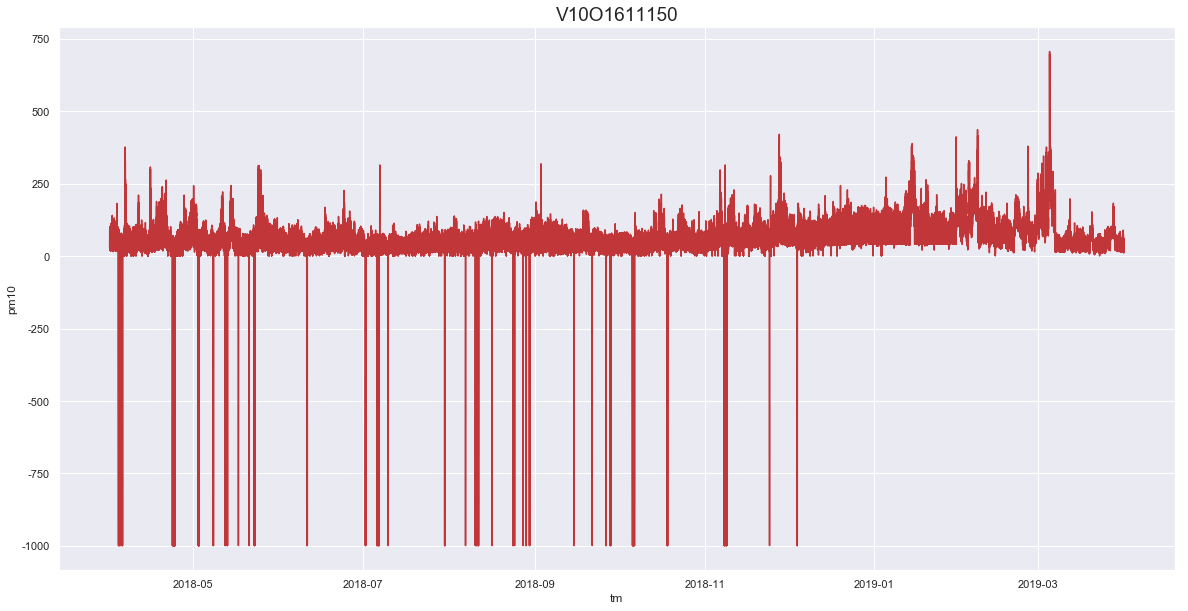

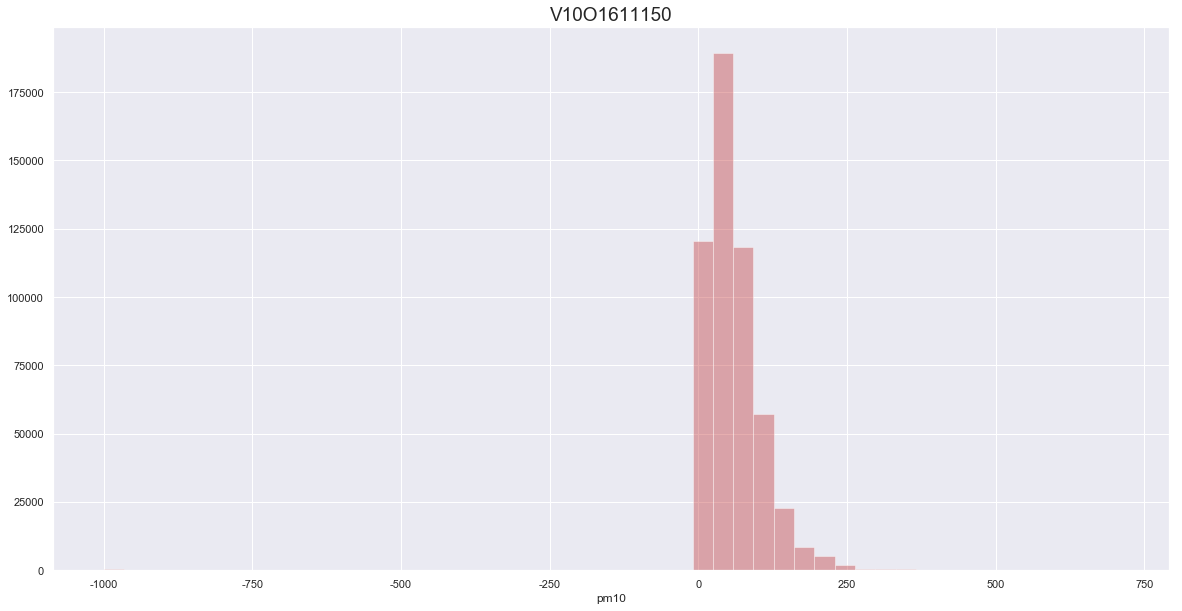

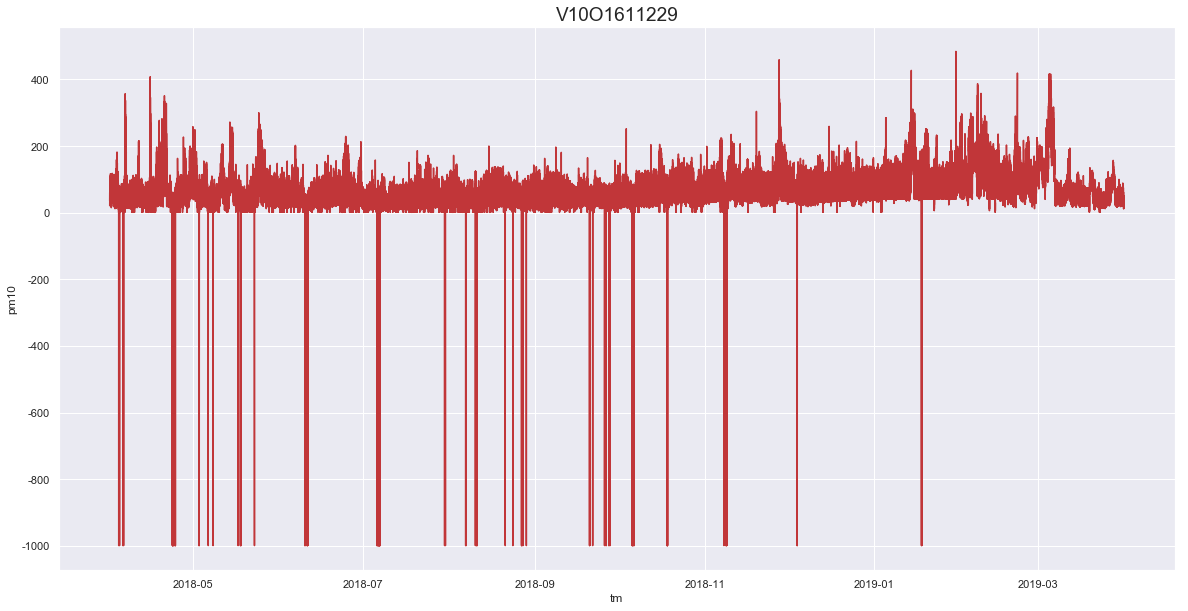

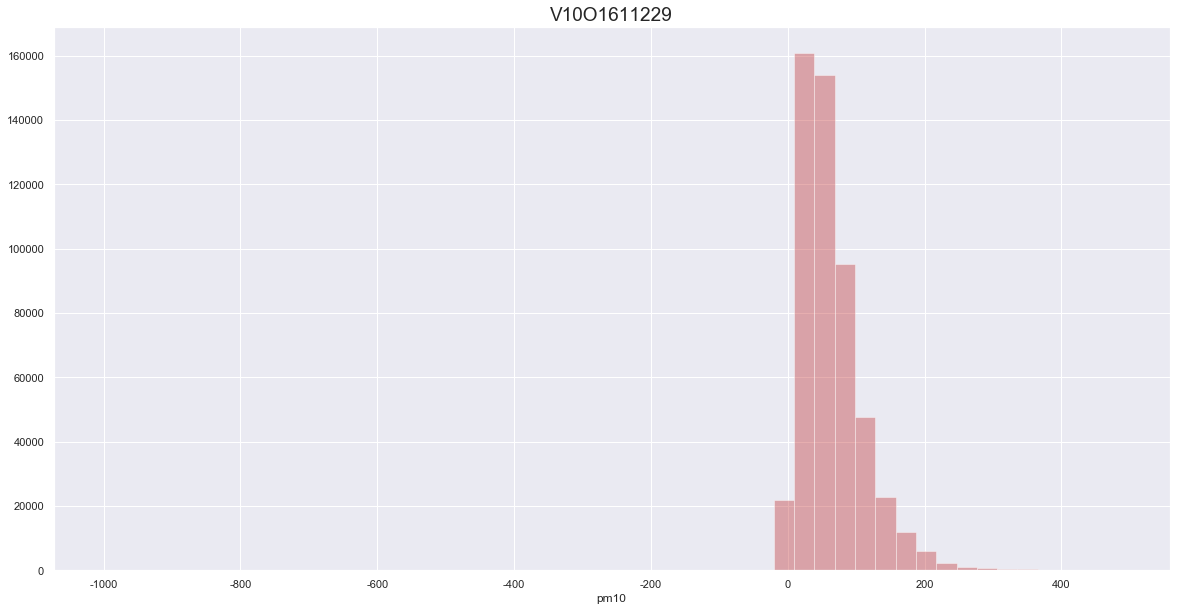

In [ ]:
# nowon['serial'] 15~19
for a in np.unique(nowon['serial'])[15:20]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=nowon[nowon['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(nowon[nowon['serial']==a]['pm10'],kde=False)

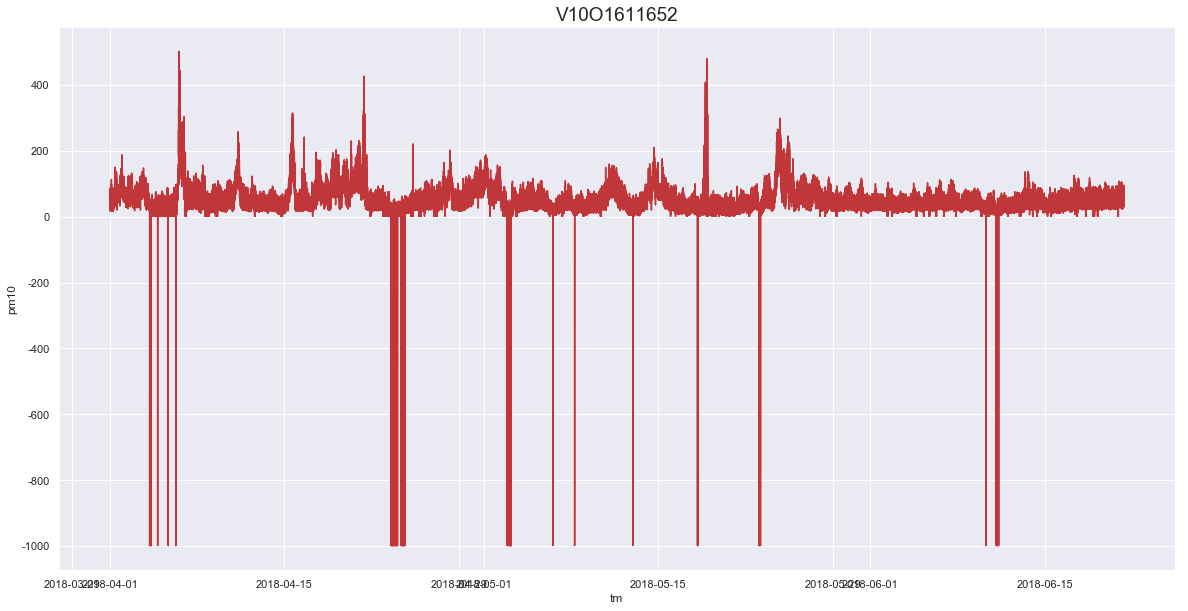

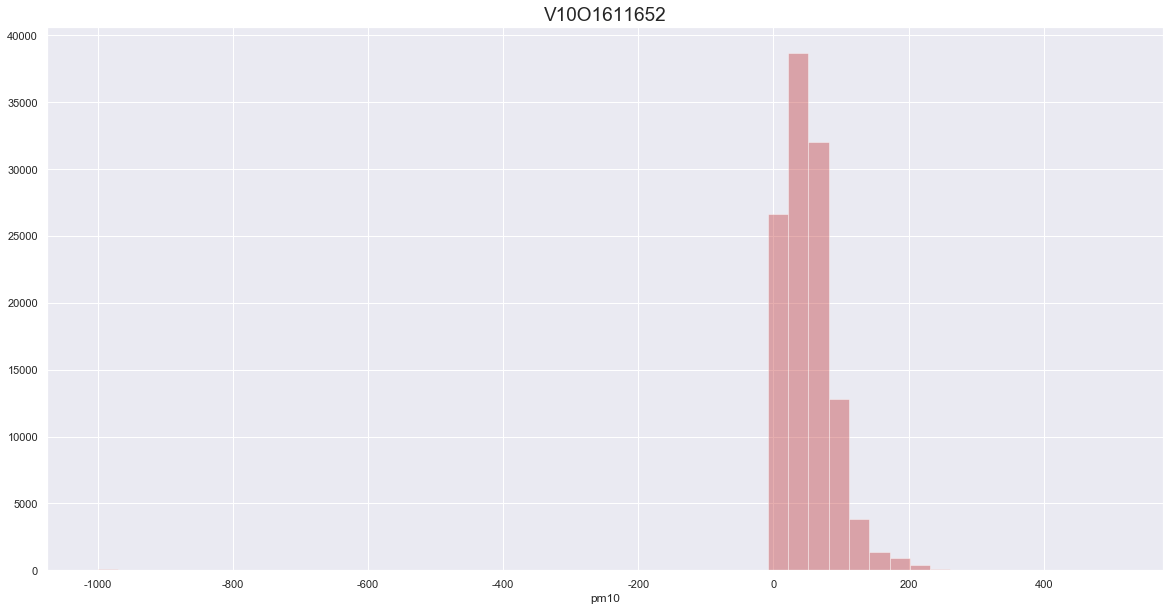

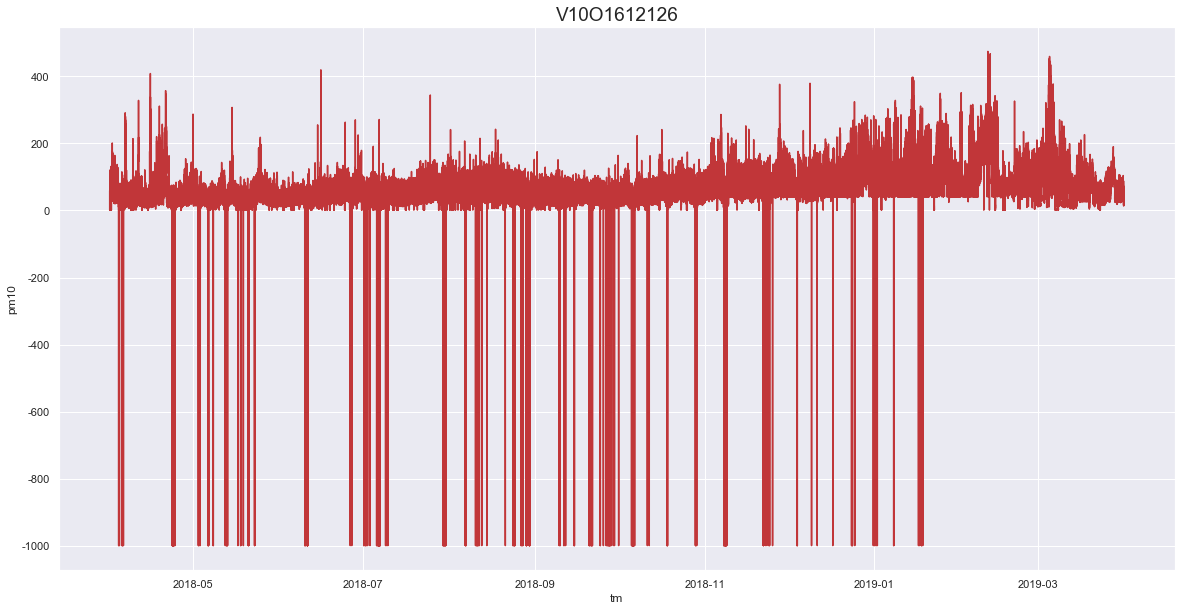

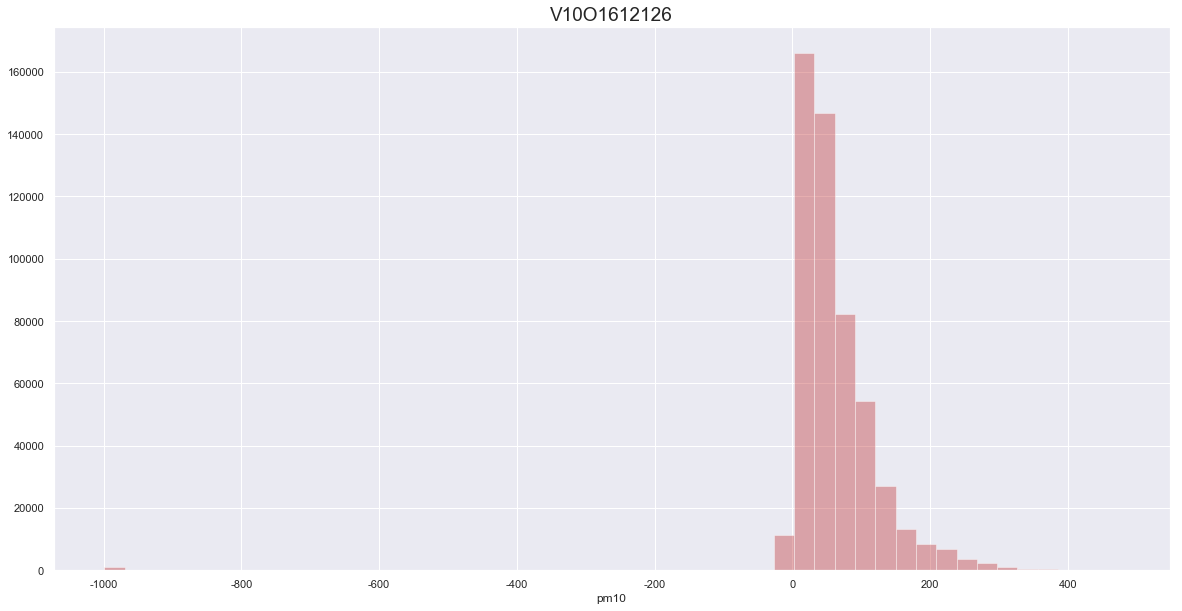

In [ ]:
# nowon['serial'] 20~21
for a in np.unique(nowon['serial'])[20:22]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=nowon[nowon['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(nowon[nowon['serial']==a]['pm10'],kde=False)

#### jonglo data - 'serial' 별  x = 'tm', y = 'pm10' 그래프

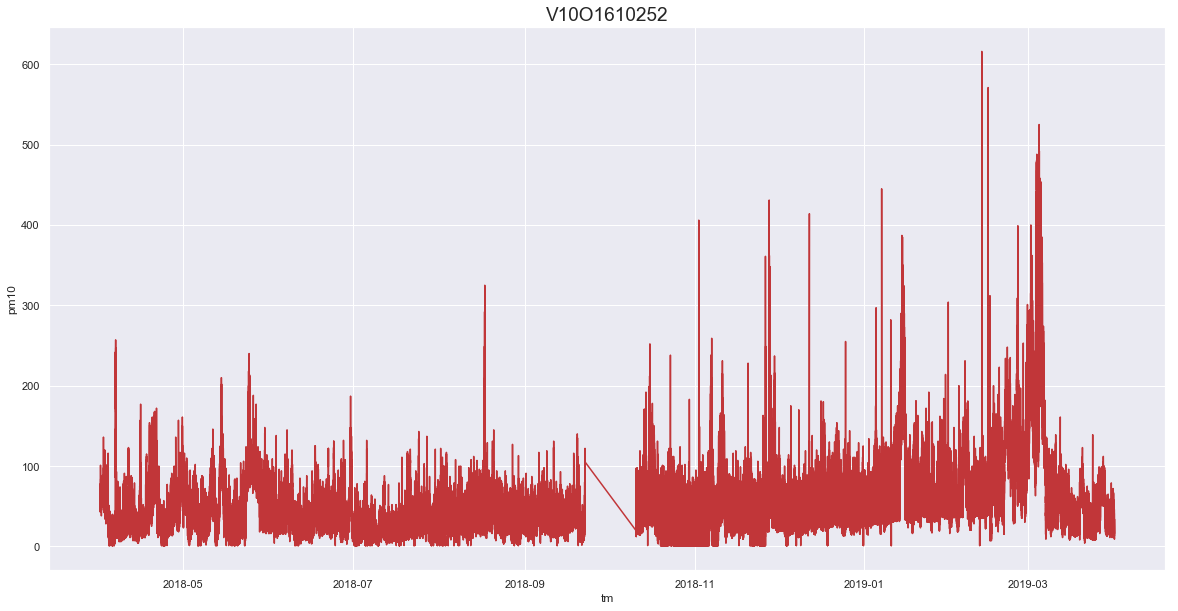

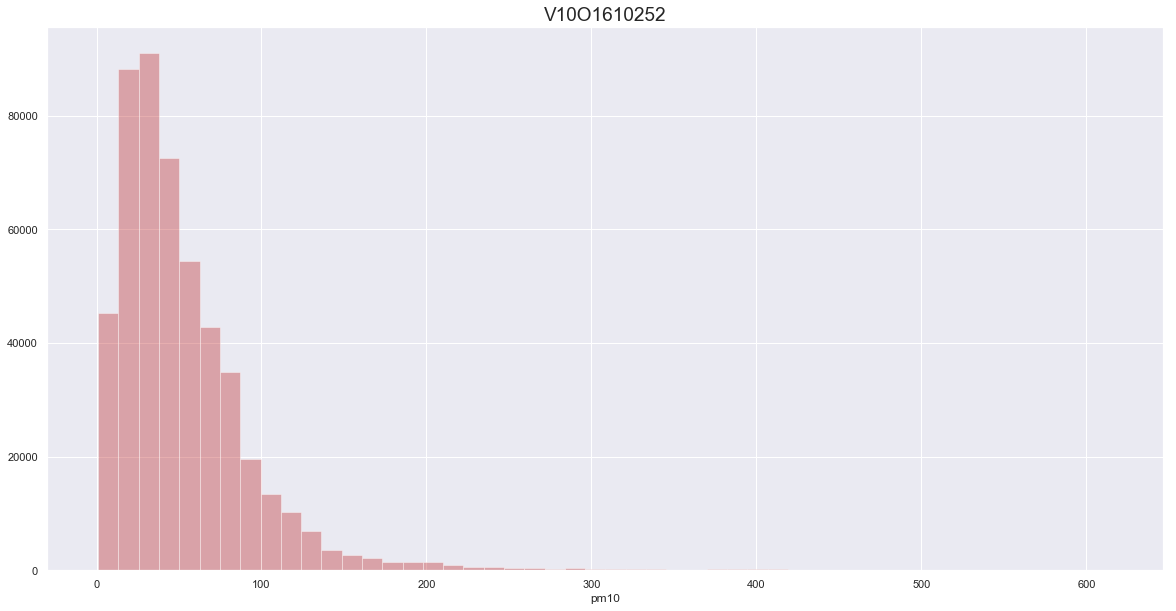

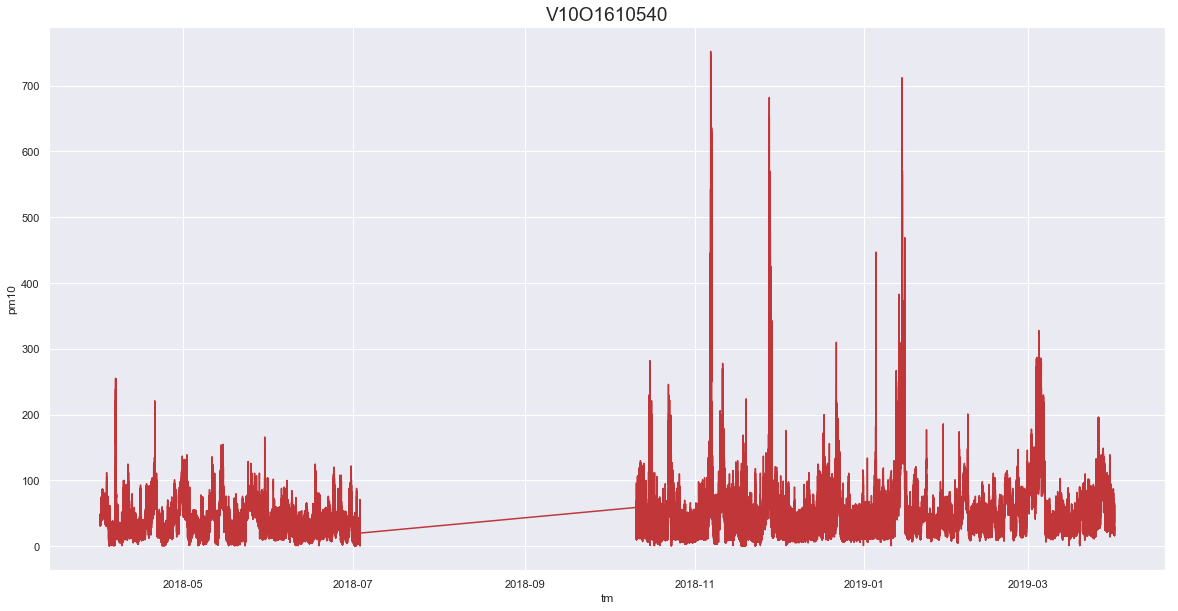

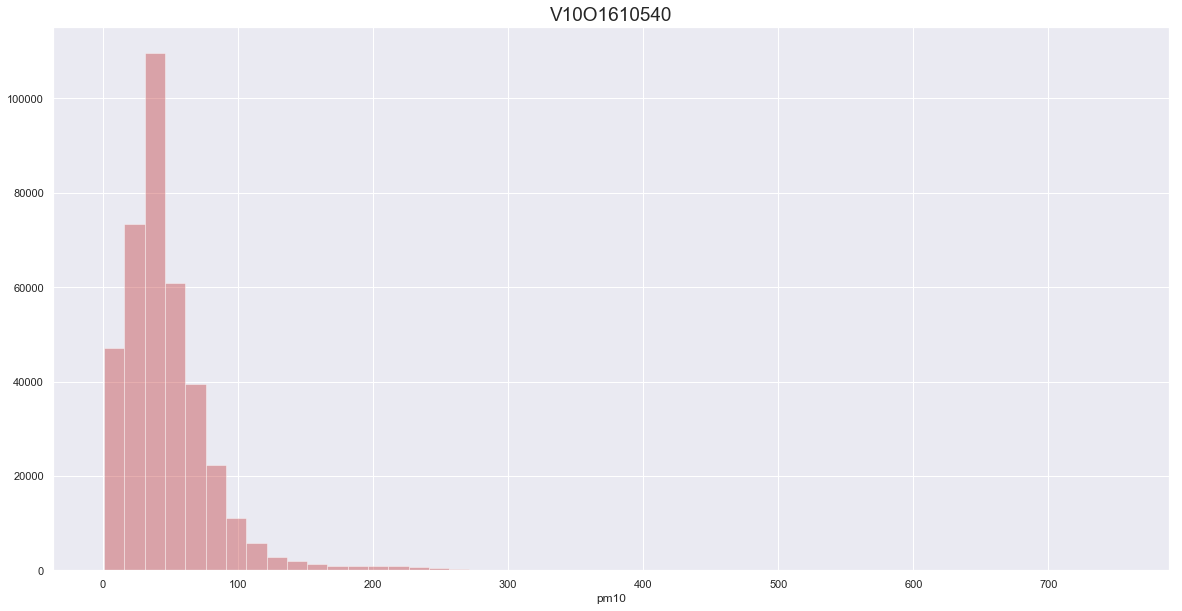

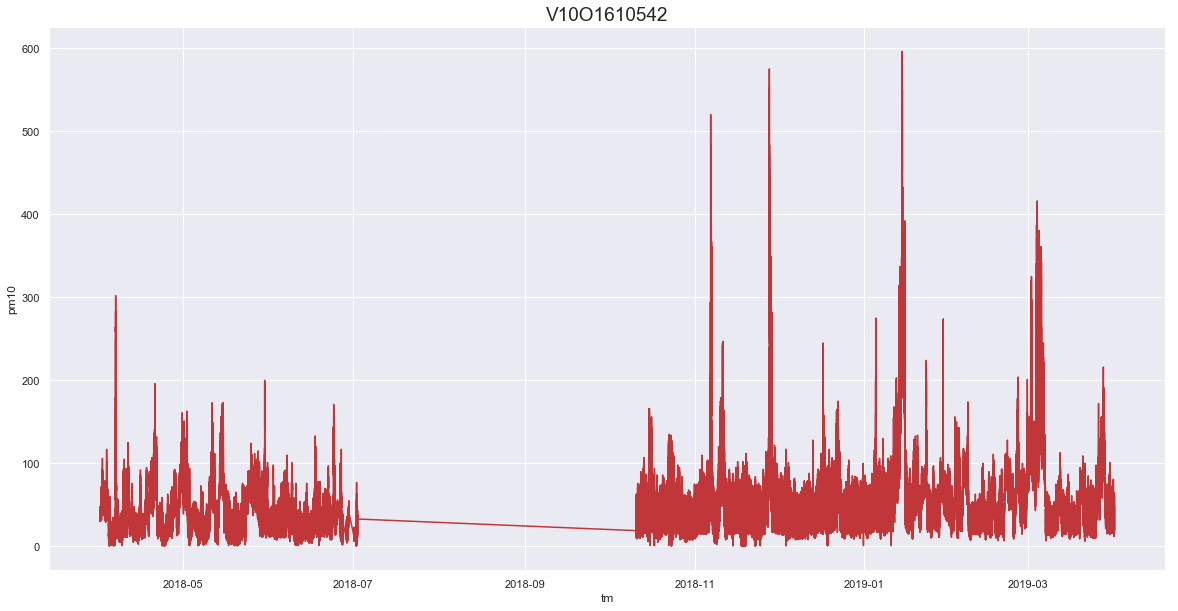

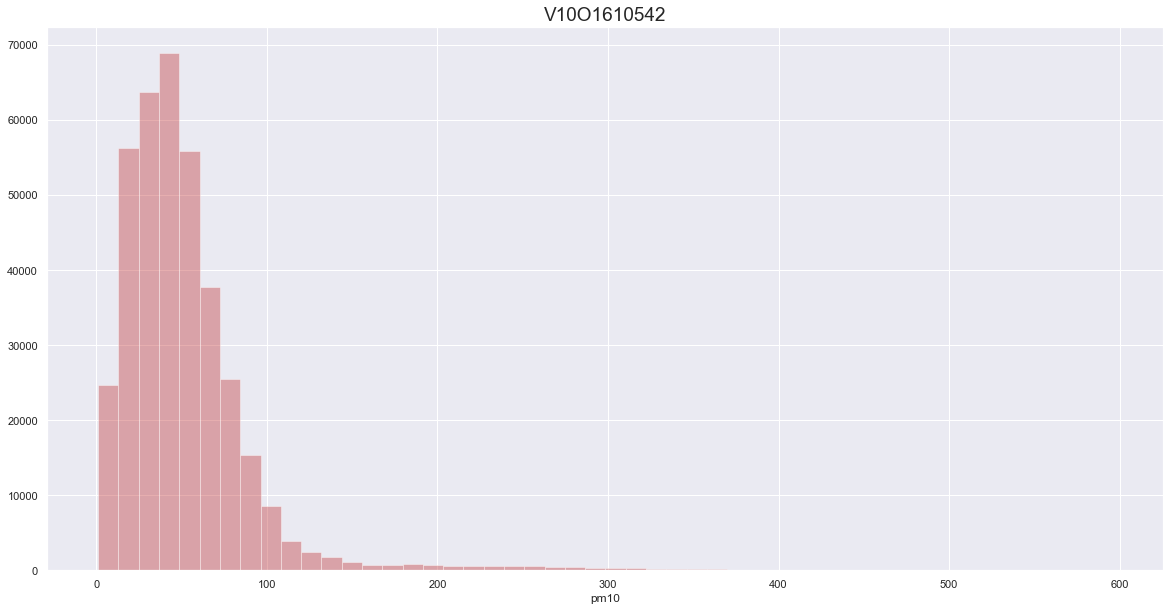

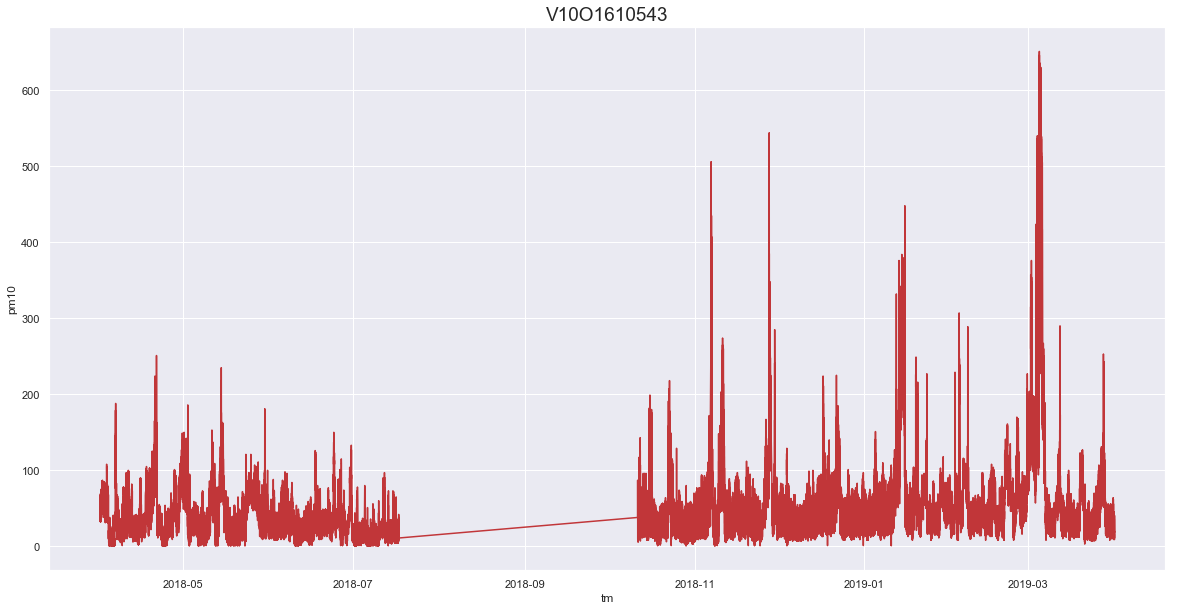

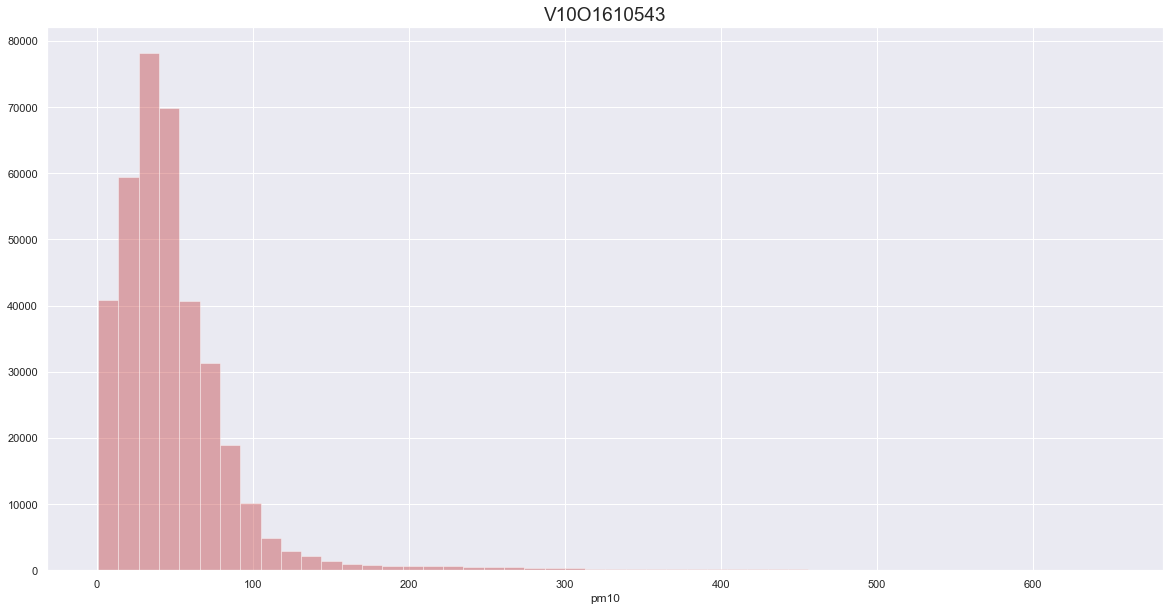

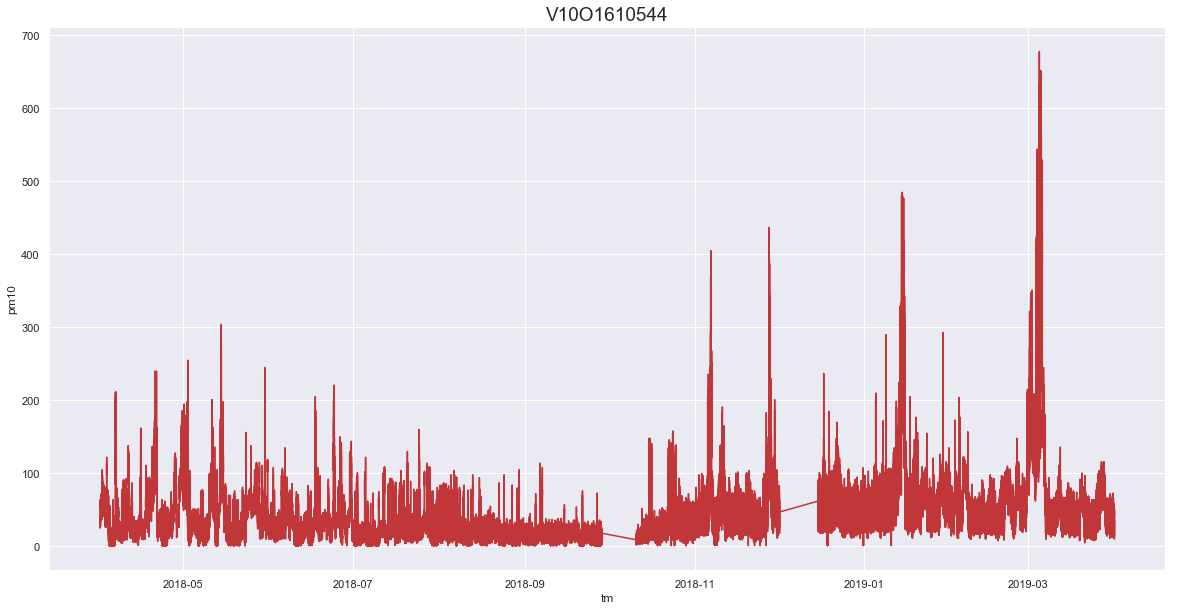

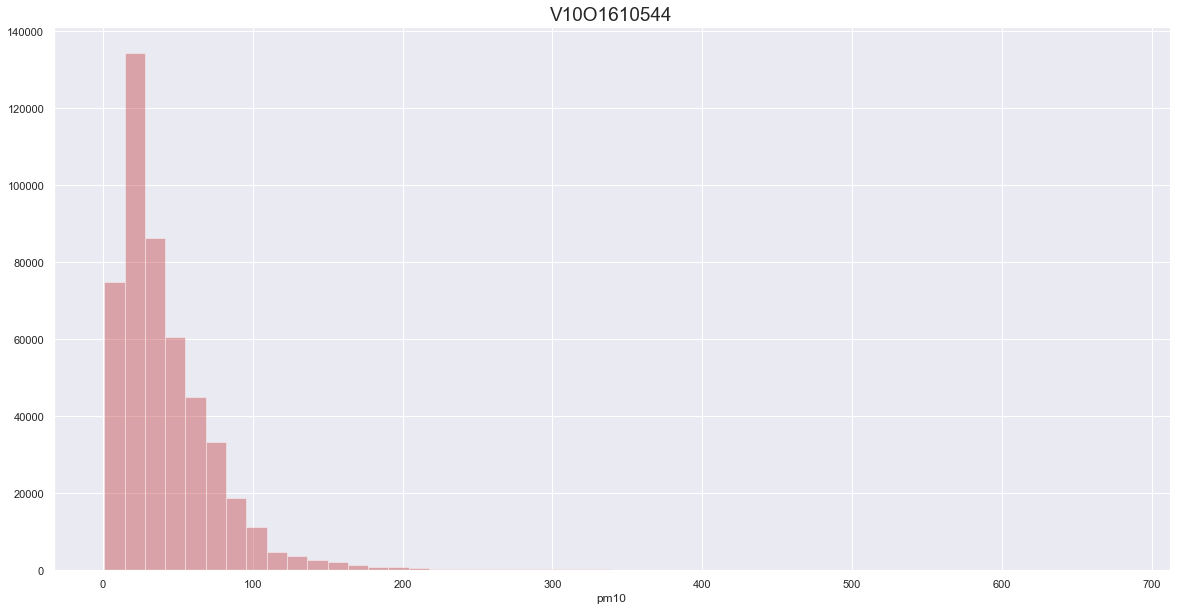

In [ ]:
# jonglo['serial'] 1~4
for a in np.unique(jonglo['serial'])[:5]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=jonglo[jonglo['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(jonglo[jonglo['serial']==a]['pm10'],kde=False)

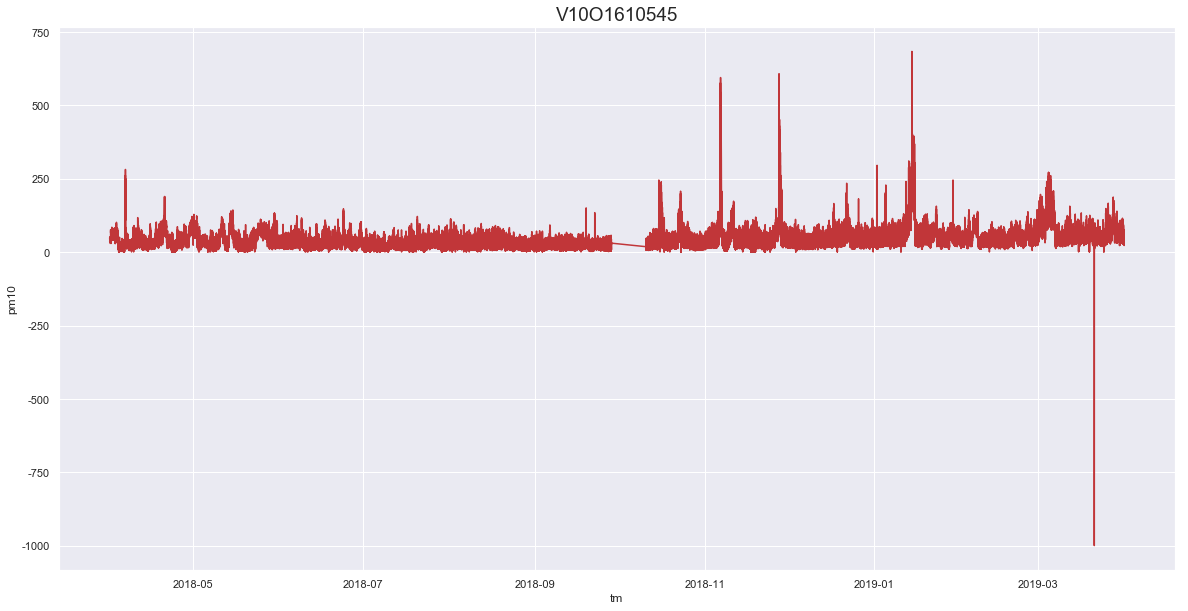

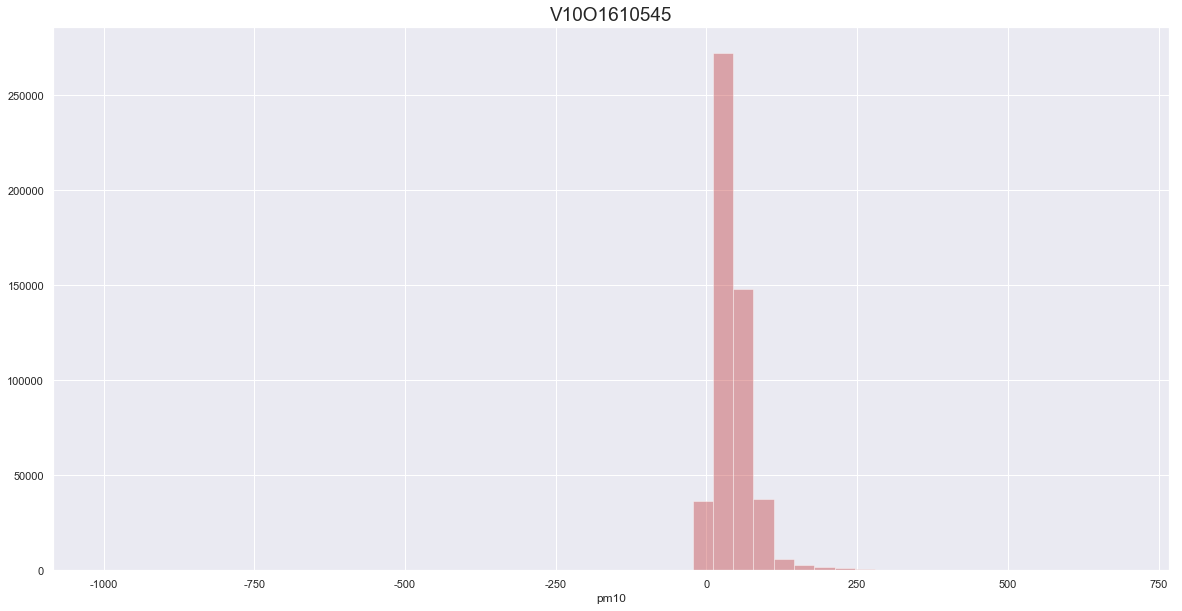

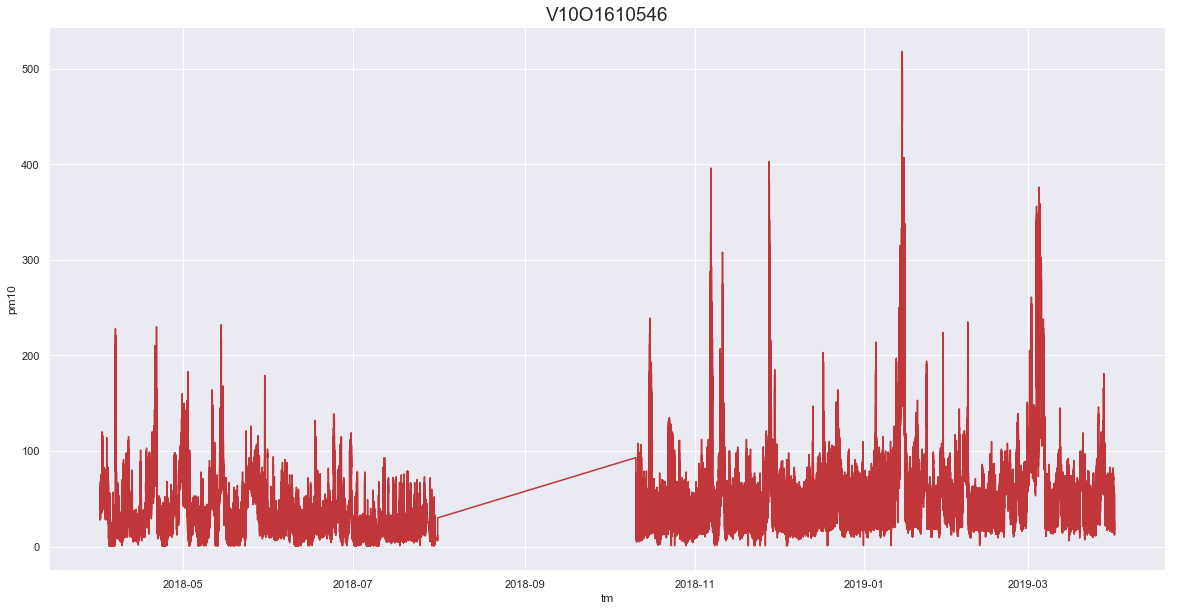

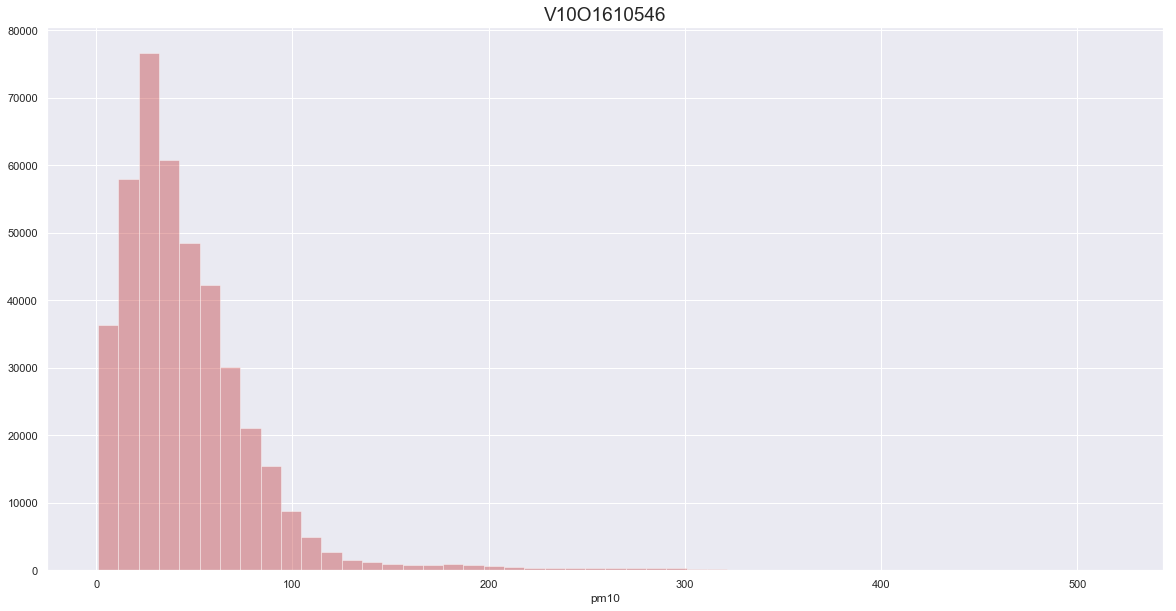

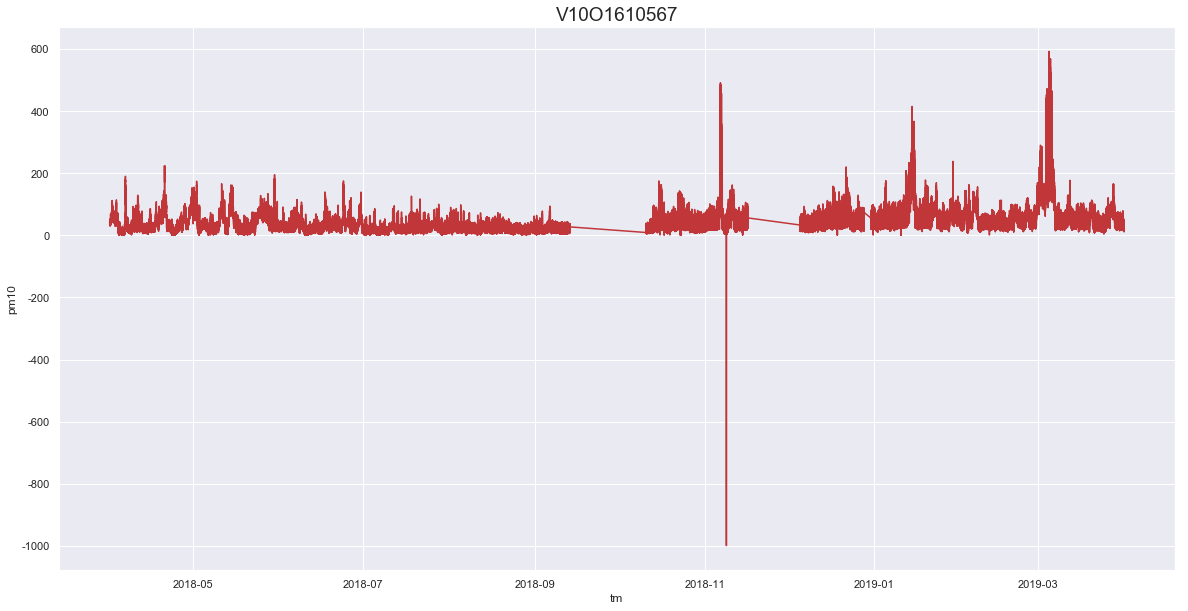

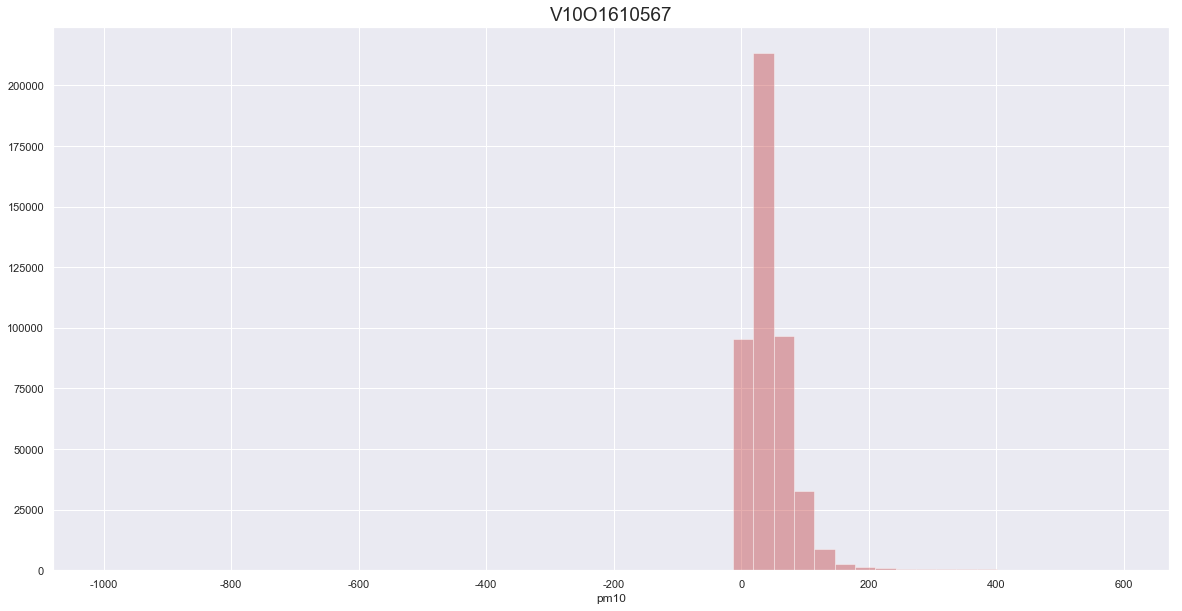

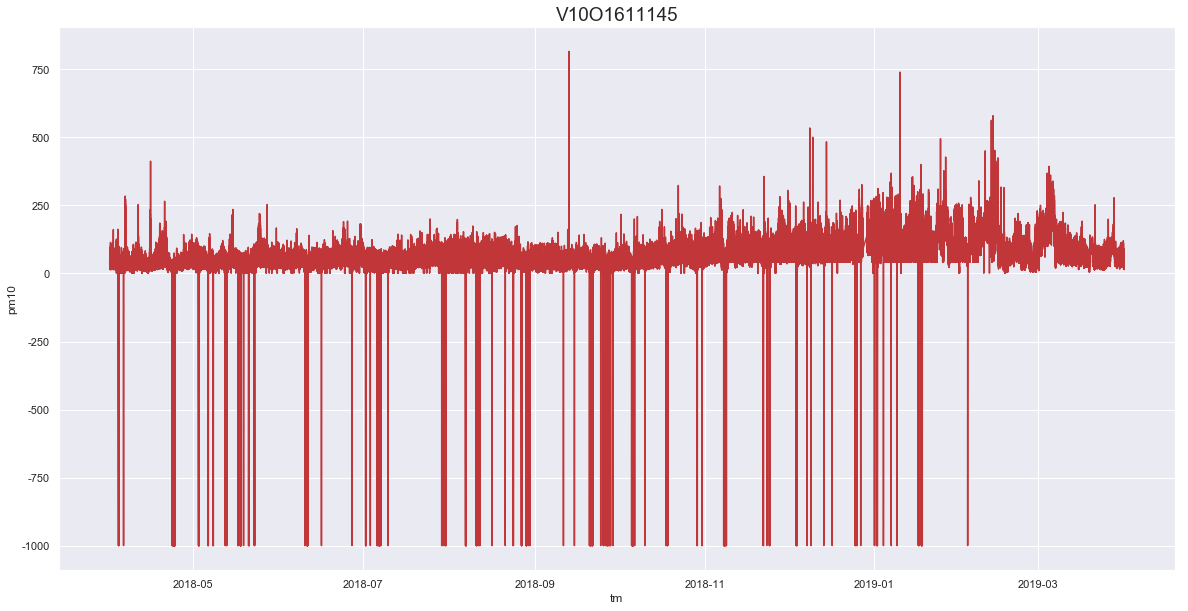

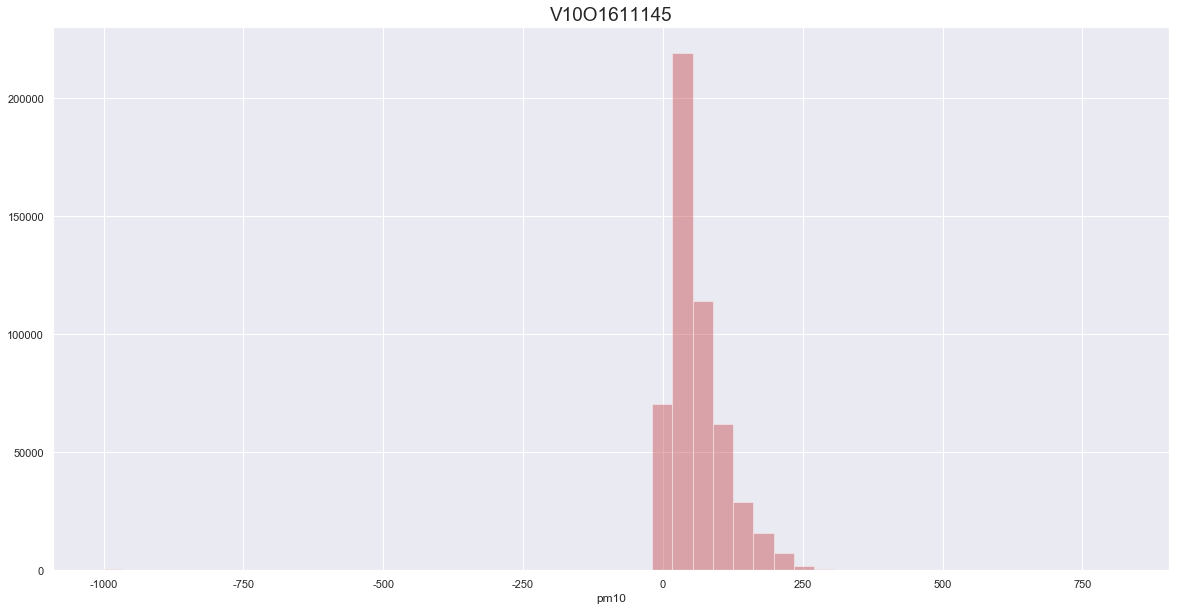

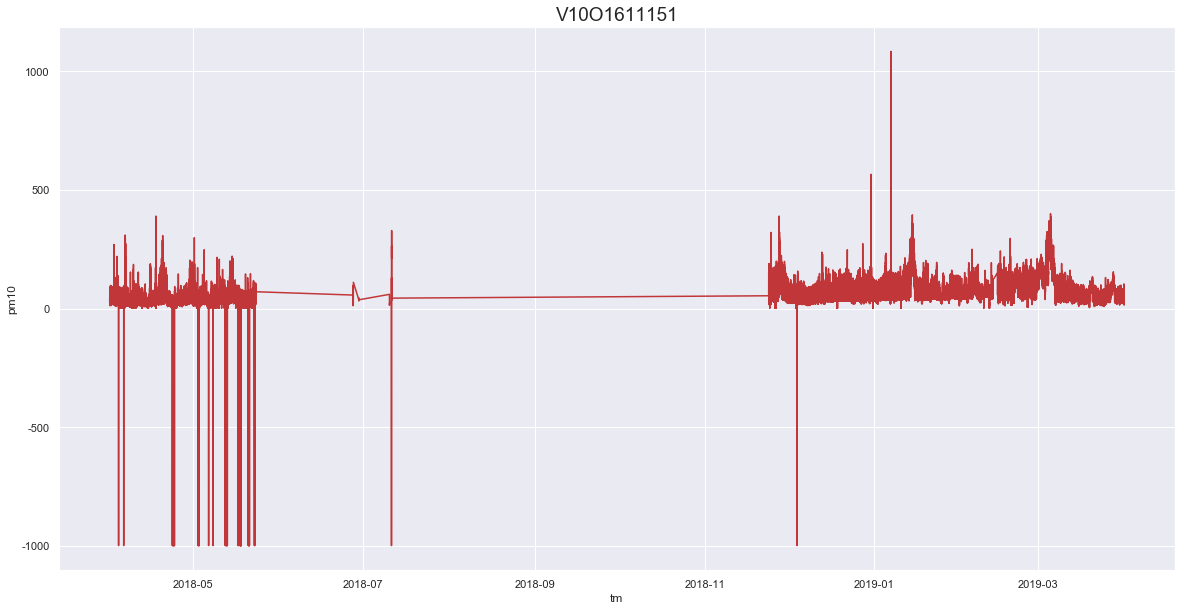

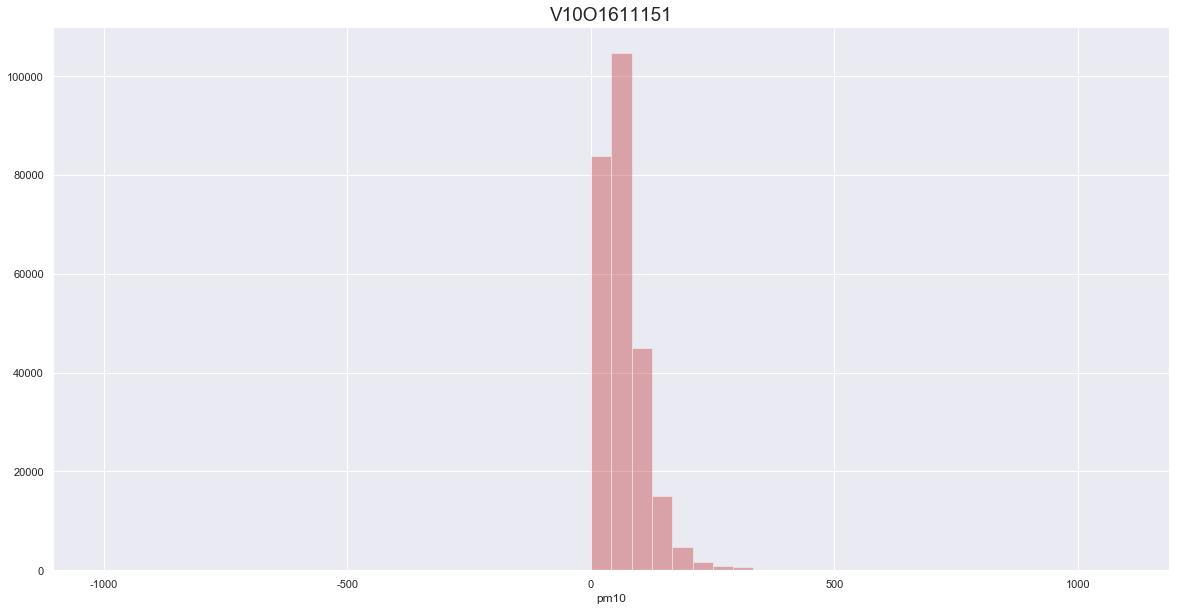

In [ ]:
# jonglo['serial'] 5~9
for a in np.unique(jonglo['serial'])[5:10]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=jonglo[jonglo['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(jonglo[jonglo['serial']==a]['pm10'],kde=False)

In [ ]:
# jonglo['serial'] 10~14
for a in np.unique(jonglo['serial'])[10:15]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=jonglo[jonglo['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(jonglo[jonglo['serial']==a]['pm10'],kde=False)

In [ ]:
# jonglo['serial'] 15~19
for a in np.unique(jonglo['serial'])[15:20]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=jonglo[jonglo['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(jonglo[jonglo['serial']==a]['pm10'],kde=False)

In [ ]:
# jonglo['serial'] 20~24
for a in np.unique(jonglo['serial'])[20:25]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=jonglo[jonglo['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(jonglo[jonglo['serial']==a]['pm10'],kde=False)

In [ ]:
# jonglo['serial'] 25~29
for a in np.unique(jonglo['serial'])[25:30]:
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.lineplot(x='tm',y='pm10',data=jonglo[jonglo['serial']==a])
    print()
    sns.set(style='darkgrid',palette = 'RdBu')
    plt.figure(figsize = (20,10))
    plt.title(a,size=19)
    sns.distplot(jonglo[jonglo['serial']==a]['pm10'],kde=False)

#### 시간 기준 별 그래프 

In [ ]:
air1.groupby(['day'])[['pm10','pm25']].median().plot()

In [ ]:
air1.groupby(['hour'])[['pm10','pm25']].median().plot()

In [ ]:
air1.groupby(['day','hour'])[['pm10','pm25']].median().plot()

In [ ]:
air1.groupby(['day'])[['humi','noise','temp']].median().plot()

In [ ]:
air1.groupby(['hour'])[['humi','noise','temp']].median().plot()

In [ ]:
air1.groupby(['day','hour'])[['humi','noise','temp']].median().plot()

In [ ]:
air1.groupby(['serial'])[['pm10','pm25']].median().plot()